In [1]:
import numpy as np
import pandas as pd

In [4]:
import pandas as pd

# List of your CSV file names
file_names = ['final_labels_MBIC.csv', 'final_labels_SG1.csv', 'final_labels_SG2.csv']

# Columns to keep
columns_to_use = ['text', 'topic', 'type', 'biased_words']

# Load and filter each file
dfs = [pd.read_csv(file, sep=';', usecols=columns_to_use) for file in file_names]

# Combine all DataFrames into one
combined_df = pd.concat(dfs, ignore_index=True)

# Optional: Check the combined data
print(combined_df.head())

# Save to a new CSV
combined_df.to_csv('combined_labels.csv', index=False, sep=';')


                                                text           topic    type  \
0  YouTube is making clear there will be no “birt...  elections-2020  center   
1  So while there may be a humanitarian crisis dr...     immigration    left   
2  Looking around the United States, there is nev...        abortion   right   
3  The Republican president assumed he was helpin...     environment    left   
4  The explosion of the Hispanic population has l...    student-debt   right   

                                        biased_words  
0                          ['belated', 'birtherism']  
1                                         ['crisis']  
2  ['killing', 'never', 'developing', 'humans', '...  
3                    ['rejects', 'happy', 'assumed']  
4                                      ['explosion']  


In [7]:
df = pd.read_csv("combined_labels.csv",sep=';')

In [10]:
df.shape

(7074, 4)

In [11]:
df["type"].value_counts()

type
left      2377
right     2375
center    1322
Name: count, dtype: int64

In [14]:
# Drop duplicates based on text
df.drop_duplicates(subset='text', inplace=True)

In [15]:
df["type"].value_counts()

type
right     997
left      994
center    692
Name: count, dtype: int64

In [16]:
df.columns

Index(['text', 'topic', 'type', 'biased_words'], dtype='object')

### using multiple ml models

In [6]:
df = pd.read_csv("final_labels_SG1.csv",sep=';')

In [14]:
df["type"].value_counts()

type
left      694
right     691
center    315
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           1700 non-null   object
 1   news_link      1672 non-null   object
 2   outlet         1700 non-null   object
 3   topic          1700 non-null   object
 4   type           1700 non-null   object
 5   label_bias     1700 non-null   object
 6   label_opinion  1700 non-null   object
 7   biased_words   1700 non-null   object
dtypes: object(8)
memory usage: 106.4+ KB


In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Load data
df = pd.read_csv("final_labels_SG1.csv", sep=';')

# Drop duplicates and nulls
df.drop_duplicates(inplace=True)
df.dropna(subset=["text", "type"], inplace=True)

# Combine text features
df["input_text"] = (
    df["text"].astype(str) + " " +
    #df["outlet"].astype(str) + " " +
    df["topic"].astype(str) + " " +
    #df["label_bias"].astype(str) + " " +
    #df["label_opinion"].astype(str)
)

# Encode target
le = LabelEncoder()
df["label"] = le.fit_transform(df["type"])  # 0=center, 1=left, 2=right (or similar depending on order)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df["input_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Multinomial NB": MultinomialNB(),
    "Linear SVC": LinearSVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    end_time = time.time()
    
    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Training Logistic Regression...
Time taken: 1.12 seconds
Accuracy: 0.9823529411764705
Classification Report:
               precision    recall  f1-score   support

      center       1.00      0.92      0.96        63
        left       0.98      0.99      0.99       139
       right       0.98      1.00      0.99       138

    accuracy                           0.98       340
   macro avg       0.99      0.97      0.98       340
weighted avg       0.98      0.98      0.98       340

Confusion Matrix:
 [[ 58   3   2]
 [  0 138   1]
 [  0   0 138]]

Training Random Forest...
Time taken: 0.86 seconds
Accuracy: 0.9882352941176471
Classification Report:
               precision    recall  f1-score   support

      center       1.00      0.95      0.98        63
        left       0.99      0.99      0.99       139
       right       0.98      1.00      0.99       138

    accuracy                           0.99       340
   macro avg       0.99      0.98      0.99       340
weighted avg

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:58:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 0.72 seconds
Accuracy: 0.9941176470588236
Classification Report:
               precision    recall  f1-score   support

      center       1.00      0.98      0.99        63
        left       0.99      1.00      1.00       139
       right       0.99      0.99      0.99       138

    accuracy                           0.99       340
   macro avg       1.00      0.99      0.99       340
weighted avg       0.99      0.99      0.99       340

Confusion Matrix:
 [[ 62   0   1]
 [  0 139   0]
 [  0   1 137]]


In [ ]:
#Save results to CSV (save the predictions and metrics)
results_df = pd.DataFrame({
    "actual": le.inverse_transform(y_test),
    "predicted": le.inverse_transform(y_pred),
    "text": X_test
})
results_df.to_csv("classification_results.csv", index=False)


## test + train (comparision)

In [9]:
for name, model in models.items():
    print(f"\n--- Training {name} ---")
    start_time = time.time()
    
    # Train the model
    model.fit(X_train_vec, y_train)
    training_time = time.time() - start_time
    
    # Predict on training data
    y_train_pred = model.predict(X_train_vec)
    
    # Predict on test data
    y_test_pred = model.predict(X_test_vec)
    testing_time = time.time() - start_time

    print(f"Training time: {training_time:.2f} seconds")
    print(f"Total time (train + test): {testing_time:.2f} seconds")
    
    # Evaluate on training data
    print("\n** Training Results **")
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Classification Report:\n", classification_report(y_train, y_train_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
    
    # Evaluate on test data
    print("\n** Test Results **")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



--- Training Logistic Regression ---
Training time: 0.15 seconds
Total time (train + test): 0.15 seconds

** Training Results **
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

      center       1.00      1.00      1.00       252
        left       1.00      1.00      1.00       555
       right       1.00      1.00      1.00       553

    accuracy                           1.00      1360
   macro avg       1.00      1.00      1.00      1360
weighted avg       1.00      1.00      1.00      1360

Confusion Matrix:
 [[252   0   0]
 [  0 555   0]
 [  0   0 553]]

** Test Results **
Accuracy: 0.9823529411764705
Classification Report:
               precision    recall  f1-score   support

      center       1.00      0.92      0.96        63
        left       0.98      0.99      0.99       139
       right       0.98      1.00      0.99       138

    accuracy                           0.98       340
   macro avg       0.99      0.97      0.

C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:09:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training time: 0.86 seconds
Total time (train + test): 0.87 seconds

** Training Results **
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

      center       1.00      1.00      1.00       252
        left       1.00      1.00      1.00       555
       right       1.00      1.00      1.00       553

    accuracy                           1.00      1360
   macro avg       1.00      1.00      1.00      1360
weighted avg       1.00      1.00      1.00      1360

Confusion Matrix:
 [[252   0   0]
 [  0 555   0]
 [  0   0 553]]

** Test Results **
Accuracy: 0.9941176470588236
Classification Report:
               precision    recall  f1-score   support

      center       1.00      0.98      0.99        63
        left       0.99      1.00      1.00       139
       right       0.99      0.99      0.99       138

    accuracy                           0.99       340
   macro avg       1.00      0.99      0.99       340
weighted avg       0.99  

### Full ML Training + Evaluation Script (with Plots + CSV Summary)

### Final Version


--- Training Logistic Regression ---
Training time: 0.13 seconds

** Training Results **
Accuracy: 0.6757352941176471
              precision    recall  f1-score   support

      center       0.00      0.00      0.00       252
        left       0.66      0.83      0.74       555
       right       0.69      0.83      0.75       553

    accuracy                           0.68      1360
   macro avg       0.45      0.55      0.50      1360
weighted avg       0.55      0.68      0.61      1360



C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

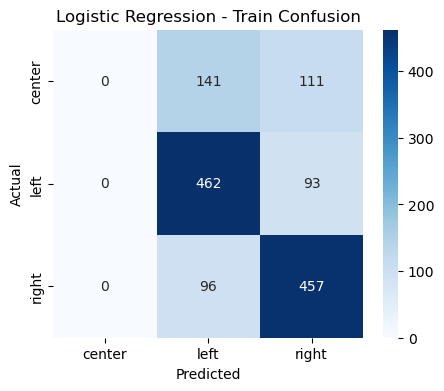


** Test Results **
Accuracy: 0.5411764705882353
              precision    recall  f1-score   support

      center       0.00      0.00      0.00        63
        left       0.52      0.67      0.58       139
       right       0.57      0.66      0.61       138

    accuracy                           0.54       340
   macro avg       0.36      0.44      0.40       340
weighted avg       0.44      0.54      0.49       340



C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

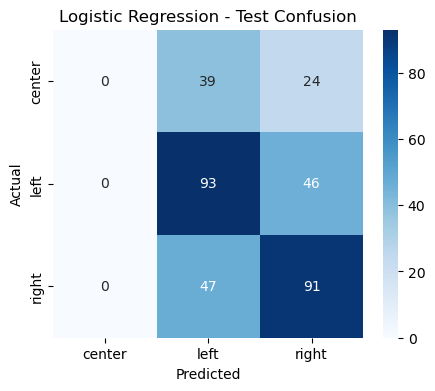


--- Training Random Forest ---
Training time: 0.34 seconds

** Training Results **
Accuracy: 0.6455882352941177
              precision    recall  f1-score   support

      center       1.00      0.00      0.01       252
        left       0.62      0.83      0.71       555
       right       0.68      0.75      0.71       553

    accuracy                           0.65      1360
   macro avg       0.77      0.53      0.48      1360
weighted avg       0.71      0.65      0.58      1360



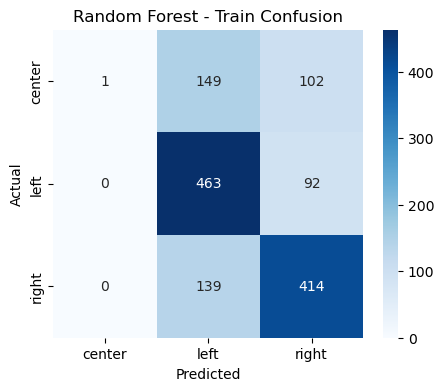


** Test Results **
Accuracy: 0.5470588235294118
              precision    recall  f1-score   support

      center       0.00      0.00      0.00        63
        left       0.51      0.73      0.60       139
       right       0.60      0.62      0.61       138

    accuracy                           0.55       340
   macro avg       0.37      0.45      0.40       340
weighted avg       0.45      0.55      0.49       340



C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

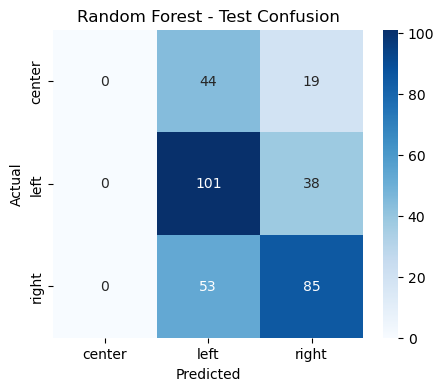


--- Training Multinomial NB ---
Training time: 0.14 seconds

** Training Results **
Accuracy: 0.7941176470588235
              precision    recall  f1-score   support

      center       0.93      0.54      0.68       252
        left       0.78      0.85      0.81       555
       right       0.78      0.85      0.81       553

    accuracy                           0.79      1360
   macro avg       0.83      0.75      0.77      1360
weighted avg       0.81      0.79      0.79      1360



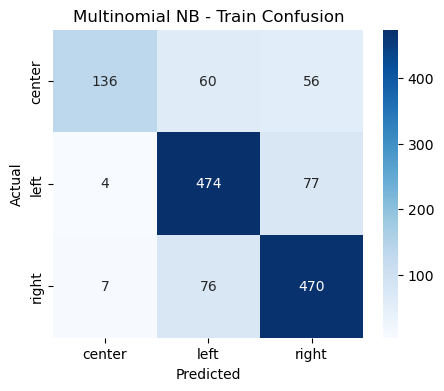


** Test Results **
Accuracy: 0.5352941176470588
              precision    recall  f1-score   support

      center       0.38      0.10      0.15        63
        left       0.51      0.61      0.56       139
       right       0.58      0.66      0.61       138

    accuracy                           0.54       340
   macro avg       0.49      0.46      0.44       340
weighted avg       0.51      0.54      0.51       340



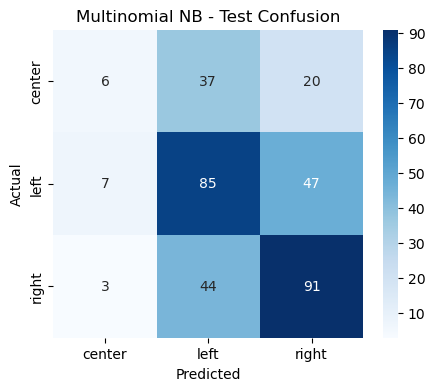


--- Training Linear SVC ---
Training time: 0.39 seconds

** Training Results **
Accuracy: 0.7808823529411765
              precision    recall  f1-score   support

      center       0.96      0.43      0.59       252
        left       0.75      0.87      0.80       555
       right       0.78      0.85      0.82       553

    accuracy                           0.78      1360
   macro avg       0.83      0.72      0.74      1360
weighted avg       0.80      0.78      0.77      1360



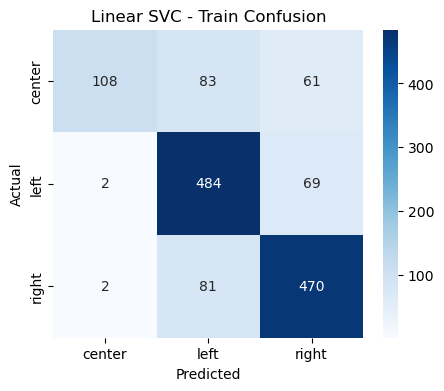


** Test Results **
Accuracy: 0.5617647058823529
              precision    recall  f1-score   support

      center       0.57      0.13      0.21        63
        left       0.53      0.64      0.58       139
       right       0.60      0.68      0.64       138

    accuracy                           0.56       340
   macro avg       0.57      0.48      0.47       340
weighted avg       0.56      0.56      0.53       340



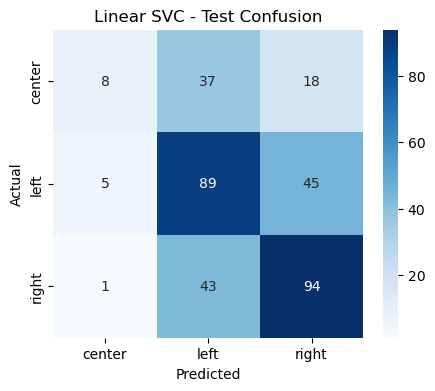


--- Training XGBoost ---
Training time: 0.86 seconds

** Training Results **
Accuracy: 0.8338235294117647
              precision    recall  f1-score   support

      center       1.00      0.57      0.73       252
        left       0.77      0.95      0.85       555
       right       0.87      0.84      0.85       553

    accuracy                           0.83      1360
   macro avg       0.88      0.79      0.81      1360
weighted avg       0.85      0.83      0.83      1360



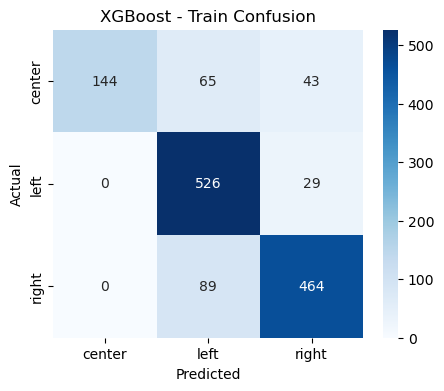


** Test Results **
Accuracy: 0.5176470588235295
              precision    recall  f1-score   support

      center       0.29      0.10      0.14        63
        left       0.51      0.68      0.58       139
       right       0.57      0.54      0.56       138

    accuracy                           0.52       340
   macro avg       0.45      0.44      0.43       340
weighted avg       0.49      0.52      0.49       340



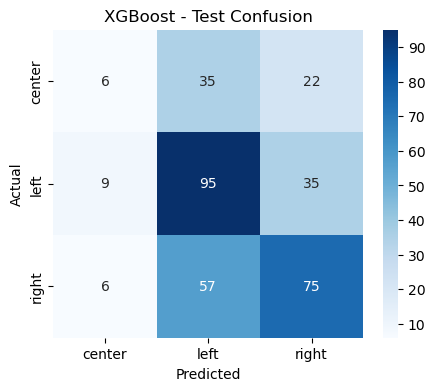


=== Summary ===
              Model  Train Accuracy  Test Accuracy  Overfitting Score  Training Time (s)
         Linear SVC        0.780882       0.561765           0.219118           0.388479
      Random Forest        0.645588       0.547059           0.098529           0.343732
Logistic Regression        0.675735       0.541176           0.134559           0.130364
     Multinomial NB        0.794118       0.535294           0.258824           0.136624
            XGBoost        0.833824       0.517647           0.316176           0.864890


In [16]:
import time
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("final_labels_SG1.csv", sep=';')  # Update path if needed
X = df["text"]
y = df["type"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Label Encoding
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)
label_names = label_encoder.classes_

# Plotting function
def plot_confusion(cm, labels, title):
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Models with tuned hyperparameters
models = {
    "Logistic Regression": LogisticRegression(C=0.1, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    "Multinomial NB": MultinomialNB(alpha=0.5),
    "Linear SVC": LinearSVC(C=0.1, max_iter=1000),
    "XGBoost": XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', verbosity=0)
}

# Store results
results = []

for name, model in models.items():
    print(f"\n--- Training {name} ---")

    use_encoded = (name == "XGBoost")
    y_tr = y_train_enc if use_encoded else y_train
    y_te = y_test_enc if use_encoded else y_test

    pipeline = make_pipeline(TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words='english'), model)

    start = time.time()
    pipeline.fit(X_train, y_tr)
    train_time = time.time() - start

    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Decode for evaluation
    if use_encoded:
        y_tr = label_encoder.inverse_transform(y_tr)
        y_te = label_encoder.inverse_transform(y_te)
        y_pred_train = label_encoder.inverse_transform(y_pred_train)
        y_pred_test = label_encoder.inverse_transform(y_pred_test)

    train_acc = accuracy_score(y_tr, y_pred_train)
    test_acc = accuracy_score(y_te, y_pred_test)
    overfit_score = train_acc - test_acc

    print(f"Training time: {train_time:.2f} seconds")

    print("\n** Training Results **")
    print(f"Accuracy: {train_acc}")
    print(classification_report(y_tr, y_pred_train))
    plot_confusion(confusion_matrix(y_tr, y_pred_train, labels=label_names), label_names, f"{name} - Train Confusion")

    print("\n** Test Results **")
    print(f"Accuracy: {test_acc}")
    print(classification_report(y_te, y_pred_test))
    plot_confusion(confusion_matrix(y_te, y_pred_test, labels=label_names), label_names, f"{name} - Test Confusion")

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Test Accuracy": test_acc,
        "Overfitting Score": overfit_score,
        "Training Time (s)": train_time
    })

# Summary table
results_df = pd.DataFrame(results)
print("\n=== Summary ===")
print(results_df.sort_values(by="Test Accuracy", ascending=False).to_string(index=False))


In [15]:
print(y.value_counts(normalize=True))

type
left      0.408235
right     0.406471
center    0.185294
Name: proportion, dtype: float64


In [18]:
df1 = pd.read_csv("final_labels_MBIC.csv", sep=";")

In [21]:
df1["type"].value_counts()

type
left      694
right     691
center    315
Name: count, dtype: int64

In [22]:
df = pd.read_csv("final_labels_SG1.csv",sep=';')
df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


In [23]:
df["type"].value_counts()

type
left      694
right     691
center    315
Name: count, dtype: int64

### combined_csv and ML (25/04/2025)

In [17]:
import pandas as pd
import numpy as np
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# ========== Load and Combine Data ==========

files = ['final_labels_MBIC.csv', 'final_labels_SG1.csv', 'final_labels_SG2.csv']
columns_common = ['text', 'topic', 'type', 'biased_words']

dfs = []

for file in files:
    df = pd.read_csv(file, sep=';')
    
    if 'MBIC' in file and 'article' in df.columns:
        df = df[columns_common + ['article']]
    else:
        df = df[columns_common]
        df['article'] = ''
    
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# ========== Preprocessing ==========

combined_df.drop_duplicates(subset=['text'], inplace=True)
combined_df.dropna(subset=["text", "type"], inplace=True)

valid_types = ['left', 'center', 'right']
combined_df = combined_df[combined_df['type'].isin(valid_types)]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
combined_df.head()

,text,topic,type,biased_words,article
0,YouTube is making clear there will be no “birt...,elections-2020,center,"['belated', 'birtherism']",YouTube says no ‘deepfakes’ or ‘birther’ video...
1,So while there may be a humanitarian crisis dr...,immigration,left,['crisis'],Speaking to the country for the first time fro...
2,"Looking around the United States, there is nev...",abortion,right,"['killing', 'never', 'developing', 'humans', '...",The left has a thing for taking babies hostage...
3,The Republican president assumed he was helpin...,environment,left,"['rejects', 'happy', 'assumed']","In Barack Obama’s first term, the administrati..."
4,The explosion of the Hispanic population has l...,student-debt,right,['explosion'],"Republicans should stop fighting amnesty, Pres..."


In [24]:
combined_df["type"].value_counts()

type
right     997
left      994
center    692
Name: count, dtype: int64

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Training Logistic Regression...
Time taken: 3.16 seconds
Accuracy: 0.8175046554934823
Classification Report:
               precision    recall  f1-score   support

      center       0.82      0.80      0.81       138
        left       0.83      0.80      0.82       199
       right       0.80      0.84      0.82       200

    accuracy                           0.82       537
   macro avg       0.82      0.82      0.82       537
weighted avg       0.82      0.82      0.82       537



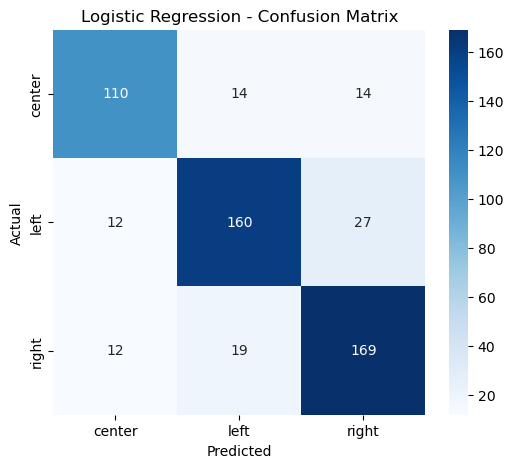


Training Random Forest...
Time taken: 3.04 seconds
Accuracy: 0.8230912476722533
Classification Report:
               precision    recall  f1-score   support

      center       0.80      0.86      0.83       138
        left       0.86      0.79      0.82       199
       right       0.81      0.83      0.82       200

    accuracy                           0.82       537
   macro avg       0.82      0.83      0.82       537
weighted avg       0.83      0.82      0.82       537



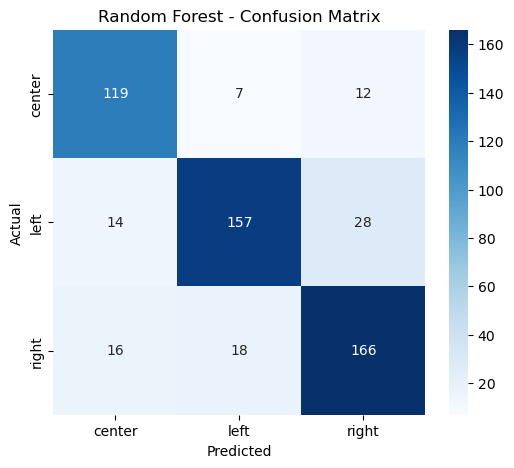


Training Multinomial NB...
Time taken: 0.01 seconds
Accuracy: 0.7188081936685289
Classification Report:
               precision    recall  f1-score   support

      center       0.84      0.47      0.60       138
        left       0.77      0.69      0.73       199
       right       0.65      0.92      0.76       200

    accuracy                           0.72       537
   macro avg       0.76      0.69      0.70       537
weighted avg       0.75      0.72      0.71       537



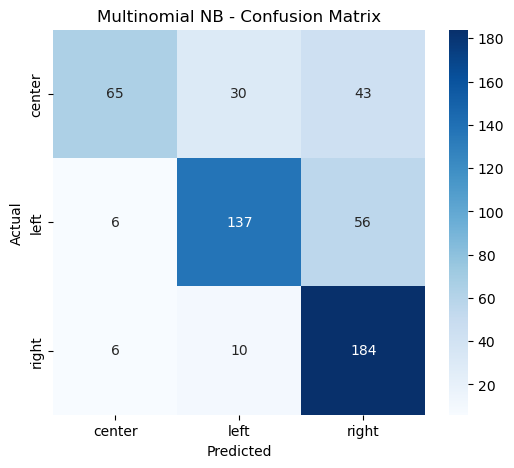


Training Linear SVC...
Time taken: 0.18 seconds
Accuracy: 0.8361266294227188
Classification Report:
               precision    recall  f1-score   support

      center       0.79      0.83      0.81       138
        left       0.88      0.82      0.85       199
       right       0.83      0.86      0.84       200

    accuracy                           0.84       537
   macro avg       0.83      0.84      0.83       537
weighted avg       0.84      0.84      0.84       537



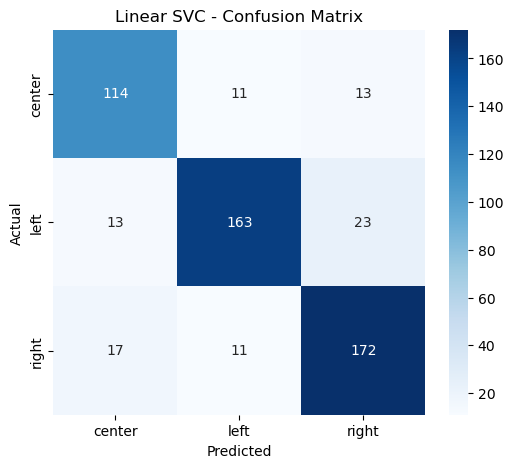


Training XGBoost...


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [23:21:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 26.05 seconds
Accuracy: 0.8230912476722533
Classification Report:
               precision    recall  f1-score   support

      center       0.82      0.79      0.80       138
        left       0.84      0.83      0.84       199
       right       0.81      0.83      0.82       200

    accuracy                           0.82       537
   macro avg       0.82      0.82      0.82       537
weighted avg       0.82      0.82      0.82       537



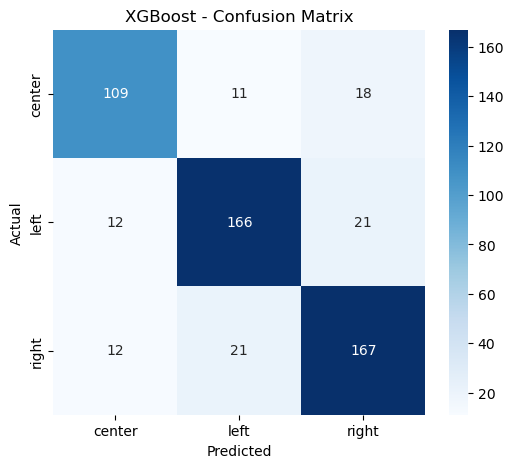

In [ ]:
import pandas as pd
import numpy as np
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# ========== Load and Combine Data ==========

files = ['final_labels_MBIC.csv', 'final_labels_SG1.csv', 'final_labels_SG2.csv']
columns_common = ['text', 'topic', 'type', 'biased_words']

dfs = []

for file in files:
    df = pd.read_csv(file, sep=';')
    
    if 'MBIC' in file and 'article' in df.columns:
        df = df[columns_common + ['article']]
    else:
        df = df[columns_common]
        df['article'] = ''
    
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# ========== Preprocessing ==========

combined_df.drop_duplicates(subset=['text'], inplace=True)
combined_df.dropna(subset=["text", "type"], inplace=True)

valid_types = ['left', 'center', 'right']
combined_df = combined_df[combined_df['type'].isin(valid_types)]

# Clean biased_words (convert stringified list to actual list)
def parse_biased_words(bw):
    try:
        return " ".join(ast.literal_eval(bw))
    except:
        return ""

combined_df['biased_words'] = combined_df['biased_words'].astype(str).apply(parse_biased_words)

# Combine all text fields
combined_df["input_text"] = (
    combined_df["text"].astype(str) + " " +
    combined_df["topic"].astype(str) + " " +
    combined_df["article"].astype(str) + " " +
    combined_df["biased_words"].astype(str)
)

# Apply stopword removal and stemming
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation
    tokens = text.lower().split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

combined_df["input_text"] = combined_df["input_text"].apply(clean_text)

# ========== Encode Labels ==========

le = LabelEncoder()
combined_df["label"] = le.fit_transform(combined_df["type"])

# ========== Train/Test Split ==========

X_train, X_test, y_train, y_test = train_test_split(
    combined_df["input_text"], combined_df["label"],
    test_size=0.2, random_state=42, stratify=combined_df["label"]
)

# ========== TF-IDF Vectorization ==========

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ========== Model Training and Evaluation ==========

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Multinomial NB": MultinomialNB(),
    "Linear SVC": LinearSVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    end_time = time.time()

    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


### ML+Best model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Training Logistic Regression...
Time taken: 2.14 seconds
Accuracy: 0.8175046554934823
Classification Report:
               precision    recall  f1-score   support

      center       0.82      0.80      0.81       138
        left       0.83      0.80      0.82       199
       right       0.80      0.84      0.82       200

    accuracy                           0.82       537
   macro avg       0.82      0.82      0.82       537
weighted avg       0.82      0.82      0.82       537



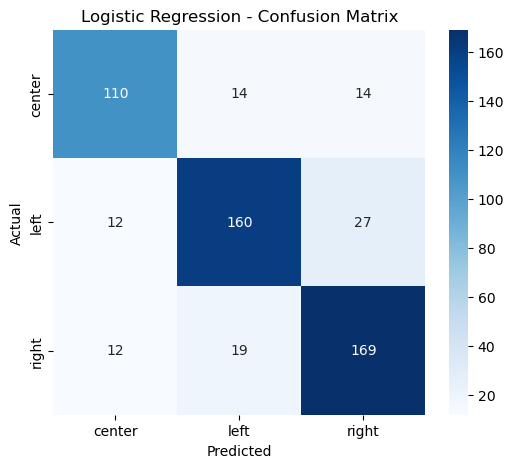


Training Random Forest...
Time taken: 4.88 seconds
Accuracy: 0.8063314711359404
Classification Report:
               precision    recall  f1-score   support

      center       0.78      0.86      0.81       138
        left       0.84      0.78      0.81       199
       right       0.80      0.80      0.80       200

    accuracy                           0.81       537
   macro avg       0.80      0.81      0.81       537
weighted avg       0.81      0.81      0.81       537



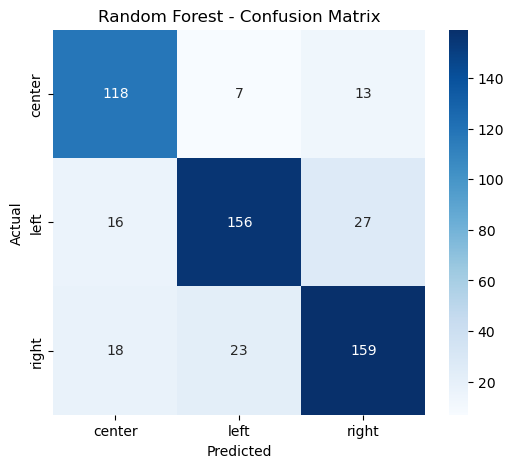


Training Multinomial NB...
Time taken: 0.01 seconds
Accuracy: 0.7188081936685289
Classification Report:
               precision    recall  f1-score   support

      center       0.84      0.47      0.60       138
        left       0.77      0.69      0.73       199
       right       0.65      0.92      0.76       200

    accuracy                           0.72       537
   macro avg       0.76      0.69      0.70       537
weighted avg       0.75      0.72      0.71       537



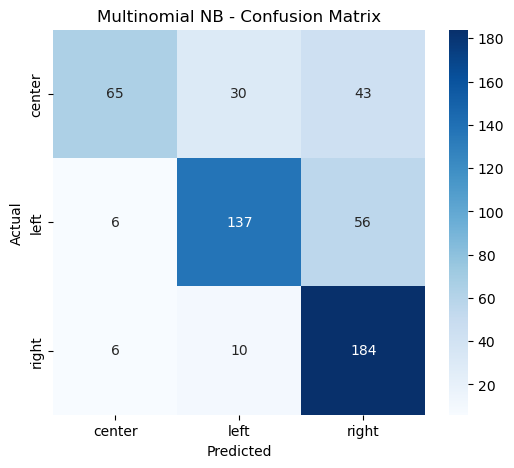


Training Linear SVC...
Time taken: 0.22 seconds
Accuracy: 0.8361266294227188
Classification Report:
               precision    recall  f1-score   support

      center       0.79      0.83      0.81       138
        left       0.88      0.82      0.85       199
       right       0.83      0.86      0.84       200

    accuracy                           0.84       537
   macro avg       0.83      0.84      0.83       537
weighted avg       0.84      0.84      0.84       537



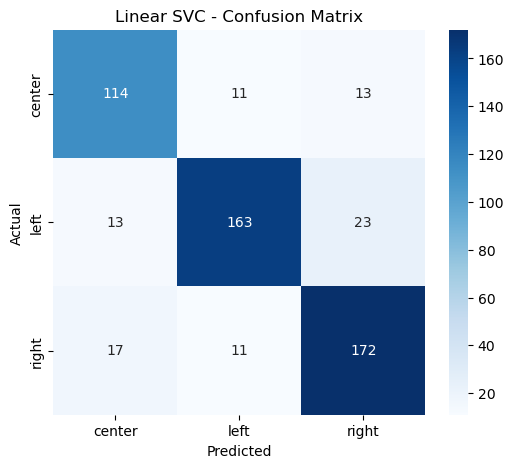


Training XGBoost...


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [11:28:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Time taken: 28.90 seconds
Accuracy: 0.8230912476722533
Classification Report:
               precision    recall  f1-score   support

      center       0.82      0.79      0.80       138
        left       0.84      0.83      0.84       199
       right       0.81      0.83      0.82       200

    accuracy                           0.82       537
   macro avg       0.82      0.82      0.82       537
weighted avg       0.82      0.82      0.82       537



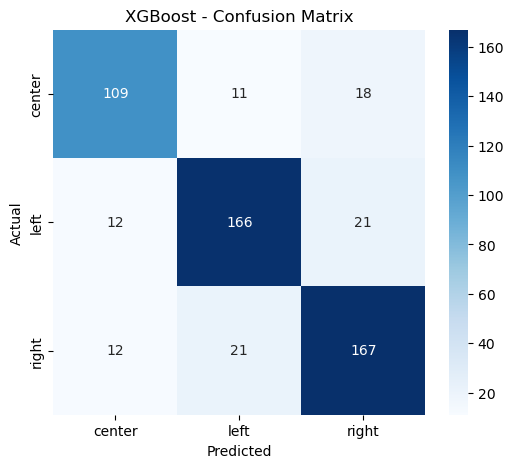


=== Model Comparison ===
                 Model  Accuracy  F1 Macro   Time (s)
0           Linear SVC  0.836127  0.833535   0.224405
1              XGBoost  0.823091  0.821120  28.898365
2  Logistic Regression  0.817505  0.816513   2.142068
3        Random Forest  0.806331  0.807058   4.878958
4       Multinomial NB  0.718808  0.698426   0.007987

🏆 Best Model: Linear SVC


In [ ]:
import pandas as pd
import numpy as np
import time
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# ========== Load and Combine Data ==========

files = ['final_labels_MBIC.csv', 'final_labels_SG1.csv', 'final_labels_SG2.csv']
columns_common = ['text', 'topic', 'type', 'biased_words']

dfs = []

for file in files:
    df = pd.read_csv(file, sep=';')
    
    if 'MBIC' in file and 'article' in df.columns:
        df = df[columns_common + ['article']]
    else:
        df = df[columns_common]
        df['article'] = ''
    
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# ========== Preprocessing ==========

combined_df.drop_duplicates(subset=['text'], inplace=True)
combined_df.dropna(subset=["text", "type"], inplace=True)

valid_types = ['left', 'center', 'right']
combined_df = combined_df[combined_df['type'].isin(valid_types)]

# Clean biased_words (convert stringified list to actual list)
def parse_biased_words(bw):
    try:
        return " ".join(ast.literal_eval(bw))
    except:
        return ""

combined_df['biased_words'] = combined_df['biased_words'].astype(str).apply(parse_biased_words)

# Combine all text fields
combined_df["input_text"] = (
    combined_df["text"].astype(str) + " " +
    combined_df["topic"].astype(str) + " " +
    combined_df["article"].astype(str) + " " +
    combined_df["biased_words"].astype(str)
)

# Apply stopword removal and stemming
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # remove punctuation
    tokens = text.lower().split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

combined_df["input_text"] = combined_df["input_text"].apply(clean_text)

# ========== Encode Labels ==========

le = LabelEncoder()
combined_df["label"] = le.fit_transform(combined_df["type"])

# ========== Train/Test Split ==========

X_train, X_test, y_train, y_test = train_test_split(
    combined_df["input_text"], combined_df["label"],
    test_size=0.2, random_state=42, stratify=combined_df["label"]
)

# ========== TF-IDF Vectorization ==========

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# ========== Model Training and Evaluation ==========

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Multinomial NB": MultinomialNB(),
    "Linear SVC": LinearSVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    end_time = time.time()

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)
    f1_macro = report['macro avg']['f1-score']
    
    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "F1 Macro": f1_macro,
        "Time (s)": end_time - start_time
    })

    print(f"Time taken: {end_time - start_time:.2f} seconds")
    print("Accuracy:", accuracy)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ========== Summary ==========

result_df = pd.DataFrame(results).sort_values(by="F1 Macro", ascending=False).reset_index(drop=True)
print("\n=== Model Comparison ===")
print(result_df)

best_model_name = result_df.loc[0, "Model"]
print(f"\n Best Model: {best_model_name}")



In [8]:
samples = [
    """Climate Crisis Escalates While Fossil Fuel Giants Rake in Record Profits. As wildfires rage across California, floods displace thousands in the Midwest, and heatwaves scorch cities from Texas to New York, the evidence is undeniable: the climate crisis is no longer a distant threat—it’s here. And yet, as communities suffer and ecosystems collapse, fossil fuel corporations continue to post record-breaking profits, protected by conservative politicians and a global system rigged in their favor. In 2024 alone, the five largest oil companies reported over $200 billion in profits. Instead of investing in renewable energy or helping vulnerable communities transition to a green economy, these corporations funneled billions into stock buybacks and executive bonuses. Their message is clear: profits come before people, and the planet can burn so long as the shareholders stay rich.
Even more alarming is the political shielding they receive from right-wing lawmakers, many of whom deny climate science altogether. Republican leaders in Congress have repeatedly blocked climate legislation, gutted the Environmental Protection Agency’s regulatory powers, and prioritized drilling permits over clean air and water. Meanwhile, climate activists—many of them youth, Indigenous leaders, and marginalized communities—continue to face police repression, surveillance, and criminalization. Peaceful protesters at pipeline sites are arrested, while oil spills and environmental destruction go unpunished. We need a Green New Deal-level transformation: bold investments in wind, solar, and green infrastructure; the creation of millions of unionized green jobs; and climate reparations for communities hit hardest by pollution and environmental racism.
The time for delay is over. The time to act is now.""",
    """America’s Strength Lies in Its Free Markets, Not Government Control. The United States thrives when government steps back and lets free enterprise lead. In recent years, however, progressive lawmakers have increasingly pushed for regulation, redistribution, and intervention that stifles innovation and discourages hard work.
From overreaching environmental mandates to government-controlled healthcare proposals, the left continues to champion policies that prioritize bureaucracy over results. These moves are not only anti-business—they’re anti-American.
America's economic engine runs best when the private sector is free to create, compete, and grow. Small business owners across the country are already struggling with inflation and labor shortages—problems worsened by excessive government interference and rising taxes.
We must return to policies that reward productivity, protect property rights, and uphold free-market values. Deregulation, tax reform, and energy independence will not only restore our economy—they’ll renew our national spirit.""",
    """Bipartisan Push Emerges for AI Regulation Amid Technological Boom. As artificial intelligence tools become increasingly integrated into everyday life—from health diagnostics to criminal justice systems—Democratic and Republican lawmakers alike are recognizing the need for clear regulatory frameworks.
A bipartisan group in Congress recently introduced the American AI Responsibility Act, aiming to address transparency, data privacy, and algorithmic bias. While the bill doesn’t go as far as some activists demand, it marks an important step toward balancing innovation with accountability.
Tech CEOs have expressed cautious support, stating that some regulation is needed to maintain public trust, but they warn against overregulation that could drive development offshore. Experts agree: regulation must be careful, measured, and informed by the science—not by political theater. While divisions remain, the shared concern over AI’s risks may offer a rare opportunity for consensus in Washington.""",
    """Republicans Block Minimum Wage Increase Despite Soaring Inequality. In yet another blow to working-class Americans, Senate Republicans have blocked legislation that would raise the federal minimum wage to $17 per hour by 2027. With wages stagnant and inflation hitting food, rent, and transportation costs, the move is being widely condemned by labor leaders and economists.
The current $7.25 minimum wage has not been raised since 2009, despite historic gains in productivity and corporate profits. Over 60% of Americans support a raise, but Republican lawmakers claim it would “hurt small businesses”—an argument that many economists say is overblown.
In reality, the refusal to raise wages preserves exploitative systems where billion-dollar corporations rely on underpaid workers while CEO salaries skyrocket.
This is not just about economics—it’s about dignity. Every American who works full-time should be able to afford basic necessities. Congress’s failure to act is a moral failure, and it’s up to voters to hold them accountable.""",
    """Border Security Improves Under New Enforcement Measures.The southern border has long been a flashpoint in American politics, but recent data shows that tougher enforcement and advanced surveillance technology are yielding results. Illegal crossings dropped 30% in the first quarter of 2025 compared to the previous year, according to Homeland Security reports.
Under the new measures, authorities have deployed AI-powered drones, reinforced border fencing, and accelerated asylum screening procedures. Critics on the left say the policies are “inhumane,” but officials argue they are necessary to protect national sovereignty and public safety.
Drug seizures have also increased, particularly fentanyl shipments originating from cartels that exploit weak border points. Law enforcement agencies say the new tools and funding are making a significant impact.
The Biden administration was slow to act early in its term, but this policy shift marks a necessary correction. The right to immigrate must be balanced with the rule of law—and American citizens deserve to feel safe and secure in their own country."""
    """Story highlights ATF whistleblower calls botched probe "egregious" Inspector general's report refers 14 for discipline; 2 already out ATF will "get off the mat again and keep swinging," acting chief saysFirearms traced to the probe were at the site of the killing of Border Patrol agent Brian TerryMore than a dozen Justice Department and Bureau of Alcohol, Tobacco, Firearms and Explosives officials 
faced punishment Wednesday after a long-awaited report on the botched gun probe known as "Operation Fast and Furious." That probe and a previous investigation were marked by "a series of misguided strategies, tactics, errors in judgment and management failures" that allowed hundreds of weapons to reach Mexican drug cartels, the Justice Department's independent inspector general concluded.Within minutes of 
the report's release, Justice announced rthat former acting ATF chief Kenneth Melson was retiring and another official, Deputy Assistant Attorney General Jason Weinstein, had resigned. Weinstein and Melson were among 14 people who "bore a share of responsibility for ATF's knowing failure in both these operations to interdict firearms illegally destined for Mexico, and for doing so without adequately taking 
into account the danger to public safety that flowed from this risky strategy," the report states. Weinstein failed to pass along key information about the flawed tactics being used in Fast and Furious, while Melson and other ATF officials didn't properly supervise the probe, the report states. The report referred them and another 12 officials in Washington and the ATF and U.S. attorney's offices in Phoenix 
to Justice officials to determine "whether discipline or other administrative action" was required. "Fast and Furious" became public after guns traced to the probe turned up at the scene of a Border Patrol agent's December 2010 killing. The resulting investigations discovered similar tactics in a 2006-2007 operation dubbed "Wide Receiver," also run out of Phoenix. Revelations that ATF agents watched suspected gun 
traffickers cross into Mexico with weapons purchased at U.S. gun shops outraged lawmakers. Larry Alt, one of the ATF agents who blew the whistle on the operation, told CNN that it was "egregious" that agents were watching people transfer guns to people who were handing them over to the cartels, "and we were not taking an enforcement action." "I would say that the persons responsible for this case ... at the field level, 
the division level, and the headquarters level and as far as it went into the Department of Justice, should be held accountable for any decision that they made that allowed these guns to go out on the street unmonitored," Alt said. Making matters worse, the Justice Department initially denied guns were being allowed to "walk" across the border, only to have to formally retract that statement in December 2011. The controversy forced Melson out at ATF, but he remained in another post at Justice until Wednesday.Acting ATF Director B. Todd Jones, meanwhile, said his agency "accepts full responsibility" for failing to oversee the Arizona probes. "This hurts. This hurts people here," Jones told reporters. But he added that the ATF has been tightening up its procedures and won't shy away from tough operations. "All we can do is get off the mat again and keep swinging," he said. The controversy fueled Republican accusations of a cover-up by the Obama administration and led to an unprecedented vote to hold Attorney General Eric Holder in contempt of Congress. The report found that Holder was not informed of the controversial ATF operation until 2011, after Border Patrol Agent Brian Terry was killed. In a written statement on the findings, Holder said the inspector-general's report upholds "what I, and other Justice Department officials, have said for many months now" -- that the tactics used pre-dated the Obama administration and that Justice Department leaders didn't try to hide the facts from lawmakers. "It is unfortunate that some were so quick to make baseless accusations before they possessed the facts about these operations -- accusations that turned out to be without foundation and that have caused a great deal of unnecessary harm and confusion," Holder said. "I hope today's report acts as a reminder of the dangers of adopting as fact unsubstantiated conclusions before an investigation of the circumstances is completed." But Iowa Republican Sen. Chuck Grassley, who brought ATF whistleblower complaints to the department's attention in early 2011, said the report "reaffirms virtually everything" that congressional investigators turned up."It's clear that both the ATF and the Justice Department failed to provide meaningful oversight of Operation Fast and Furious," Grassley said in a written statement. Those agencies "ignored warnings from employees" and refused to acknowledge how bad the problem was until after months of congressional pressure, he said. And Grassley said the report inaccurately lets Assistant Attorney General Lanny Breuer "off the hook" regarding a February 2011 letter to Congress that denied guns were being allowed to cross the border. Along with the statement, Grassley released e-mails he said contradict the report.Breuer acknowledged last November he had learned that guns were allowed to "walk" to Mexico, and apologized for not informing other senior Justice Department officials. The February 2011 letter to Grassley was later retracted by Justice officials.Wednesday's report criticized Breuer and another top official, Gary Grindler, who was acting deputy attorney general when the events took place, for failing to pass along information to the attorney general and other top officials. But they remain with the department. A standoff over internal Justice documents erupted after the Obama administration said it was asserting executive privilege in the Fast and Furious case to shield documents that include internal deliberations traditionally protected from outside eyes.That prompted the House of Representatives to vote a civil contempt charge against Holder -- the first time a Justice Department chief has been held in contempt by Congress. Democrats protested the vote vehemently as being purely political, and the citation passed along party lines. The House took the issue to court, where it is expected to linger until well beyond November's presidential election. Some of the documents the White House withheld under the privilege claim were included in the report. Grassley said that inclusion "proves that this subset of documents could have been released earlier," and the president "was merely thumbing his nose at Congress" before the contempt vote.Rep. Darrell Issa, who pushed for the contempt vote against Holder as chairman of the House Oversight and Government Affairs Committee, the report shows "widespread failures" and "a near-total disregard for public safety." "Attorney General Holder has clearly known about these unacceptable failures, yet has failed to take appropriate action for over a year and a half," added Issa, R-California. Holder had said he was awaiting the report to determine what actions to take against individuals involved in the case. But he has promised Congress that such "gun walking" of weapons into Mexico would never again be allowed. Issa called on President Barack Obama to "step up and provide accountability" for the program. And Inspector General Michael Horowitz, whose office produced the report, is scheduled to appear before Issa's committee on Thursday.""",
    """WASHINGTON (Reuters) - President Donald Trump said on Monday that he plans to display battle tanks on Washington’s National Mall as part of a pumped-up Fourth of July celebration that will also feature flyovers by fighter jets and other displays of military prowess.The military hardware is just one new element in a U.S. Independence Day pageant that will depart significantly from the nonpartisan, broadly patriotic programs that typically draw hundreds of thousands of people to the monuments in downtown Washington.While past presidents have traditionally kept a low profile on July 4, Trump plans to deliver a speech at the Lincoln Memorial.Also on the agenda are an extended fireworks display and flyovers by Air Force One, the custom Boeing 747 used by U.S. presidents, and the U.S. Navy’s Blue Angels jet squadron.“I’m going to say a few words, and we’re going to have planes going overhead,” Trump told reporters in the Oval Office. “And we’re going to have tanks stationed outside.”Democrats in Congress have accused Trump of hijacking the event to boost his re-election prospects in 2020. They have also questioned how much the event will cost the cash-strapped National Park Service.Trump has pushed for a military parade in Washington since he marveled at the Bastille Day military parade in Paris in 2017. His administration postponed a parade that had been planned for Veterans Day in November 2018 after costs ballooned to $90 million, three times the initial estimate.Trump said modern M1 Abrams tanks and World War Two-era Sherman tanks would both be on display. District of Columbia officials have said the heavy military equipment could damage city streets.“You’ve got to be pretty careful with the tanks because the roads have a tendency not to like to carry heavy tanks, so we have to put them in certain areas,” Trump said.The antiwar group Code Pink said it had secured permits to fly a “Baby Trump” blimp, depicting the president in diapers, during his speech. “Babies need enormous amounts of attention and are unable to gauge the consequences of their behavior - just like Donald Trump,” co-founder Medea Benjamin said in a news release.The Interior Department, which oversees the event, has not said how much the event will cost. Two fireworks firms will put on a 35-minute display for free, which the agency said was equal to a donation of $700,000.Reporting by Andy Sullivan and Makini Brice; Additional reporting by Jeff Mason; Editing by Diane Craft and Peter Cooneyfor-phone-onlyfor-tablet-portrait-upfor-tablet-landscape-upfor-desktop-upfor-wide-desktop-up""",
    """ MSNBC will not air the entirety of President TrumpDonald TrumpBlack voters are fleeing Biden in droves. Here's why Biden's Super Bowl prediction: 'Loves' Bengals' quarterback, but Rams 'hard to beat' GOP Senate candidate to run 'Let's go Brandon' ad during Super Bowl MORE's planned "Salute to America" on July Fourth, instead opting to carry on with regularly scheduled news programming that may include clips of the event.A spokesperson for 
    the network told Politico it potentially will air parts of the event during Thursday's newscasts, which will continue normally with "The Beat with Ari Melber" airing live at 6 p.m. ET and "Hardball with Chris Matthews" at 7 p.m.The network did not immediately return The Hill's request for more information on its Thursday schedule.Fox News, meanwhile, will air the entirety of Trump's special July Fourth celebration during a live two-hour "Special Report" 
    with Mike Emanuel as guest host that is set to broadcast at 6 p.m. CNN, meanwhile, did not immediately respond to a request for comment but is currently set to air a documentary on white nationalism at 7 p.m., according to Politico.Streaming channels such as CBSN and ABC News Live both reportedly plan to air the entirety of Trump's remarks, while CBSN will cover the rest of the event as well.Trump has promised to speak at the event and told reporters during a bill signing in the Oval Office that the event, 
    which is set to include military tanks and a flyover from the new Marine One aircraft, "will be like no other."“We’re gonna have a great Fourth of July in Washington, D.C.,” the president said Monday.Critics of the president's plans for the holiday say Trump is inappropriately politicizing July Fourth and have warned about the high price tag for the event.This article was updated at 7:20 p.m. The Hill 1625 K Street, NW Suite 900 Washington DC 20006 | 202-628-8500 tel | 202-628-8503 faxThe contents of this site are © 1998 - 2022 Nexstar Media Inc. | All Rights Reserved. """,
    """Telecommunications workers Chris Viens and Guy Glover install a new 5G antenna system for AT&T's 5G wireless network in downtown San Diego, California, April 23, 2019.Mike Blake | ReutersTen years into the recovery, the economy's ability to create new jobs may be slowing, both because the U.S. is running out of workers and because the trade war may be worrying employers.Economists expect to see 165,000 jobs were added in June, after a stunningly low 75,000 payrolls added in May, according to Dow Jones. But a soft ADP report Wednesday, with just 102,000 new private payrolls, dampened expectations for the government's June payroll report, which will be released Friday at 8:30 a.m. ET.The jobs report is also seen as a major input for the Fed to consider when it meets at the end of the month, and if there is more weakness than expected in job growth or wages data, it could be another catalyst for an expected interest rate cut. In the June report, the unemployment rate is expected to hold steady at 3.6%, while average hourly wages are expected to increase by 0.3%, or 3.2% year over year, up from 3.1% in May."We've known for a while with a very low unemployment rate that we're running out of workers. Payroll gains are going to slow at some point. I don't know if this is the point or not. I don't trust the ADP number. I don't know if the day of seeing 200,000 job numbers is over," said Chris Rupkey, chief financial economist at MUFG Union Bank.ADP is not seen as a strong indicator for the government's employment report, but in May, its initial report of just 27,000, later revised to 40,000 jobs, sent a strong message about a hiring slowdown that later showed up in the government's weak May report.On the other hand, some employment indicators remain strong. Weekly jobless claims data, viewed as the most current data on the labor market, fell by 8,000 to 221,000 in late June, signaling a solid enough jobs picture when it was released Wednesday.But ADP's data also contained some worrisome details, such as the decline of 37,000 jobs in companies employing one to 19 people. "The thing that's really puzzling is the slowdown in small business hiring. That's really the engine for job growth in the economy. Seeing that slowdown is concerning," said Tom Simons, money market economist at Jefferies.So far, it's not clear how much employers are holding off on hires because they are fearful about an economic slowdown or because of uncertainty about trade or tariffs. But other data, showing slower manufacturing activity and weaker investment spending, has been a concern."Certainly, it would be a problem if jobs were weak for a second month in a row. For the Federal Reserve, they're certainly worried and teed up to cut rates on July 31. Any weakness in payrolls for a second month would be a virtual green light for a Fed rate cut," said Rupkey. "It's not going to be shocking for the market. ... But is the economy really ready to go into a tailspin with an actual downturn here? It just doesn't feel like it. Consumer spending is still high."But the average hourly wage number inside Friday's report could also be a factor for the Fed, especially if it's shy of expectations."Expectations are for a deceleration in job growth. Job growth is decelerating quite sharply from 2018. The real issue for the Fed is what's wage growth, and it's not been promising of late," said Diane Swonk, chief economist at Grant Thornton. "We've seen 3.1% after hitting a peak of 3.4%. If we stay in that 3% range, that's enough for the doves at the Fed to go. The question is can they bring the hawks along with them. They're really going to be looking at the wage number."Moody's Analytics chief economist Mark Zandi said he expects 135,000 jobs were added in June and that the report will show both a lack of workers and the impact of trade wars and tariffs on the economy. The ADP report is published in collaboration with Moody's. Zandi said the ADP report reflects just private sector hires, and he expects a surge in government workers in June."I think the trade war is causing real damage. We were going to see some slowdown anyway because we were not going to be able to fill these open positions. This feels like it's more than that. We went from a monthly gain of 225,000 last year to 165,000, and the recent numbers suggest we could be at 125,000 to 150,000. That's more than can be explained than that people can't find workers," said Zandi.At J.P. Morgan, economists are expecting a below-consensus 140,000 jobs in June."We are watching the different labor market reports for information about how the job market is responding to recent news on trade policy and other economic developments. While there have been occasional worrisome readings, overall it looks like the trend in job growth is cooling, but not in an especially severe way. We continue to forecast that Friday's BLS report will show nonfarm job growth of 140,000 in June," wrote economist Daniel Silver."""
]

# Preprocess articles the same way
sample_cleaned = [clean_text(article) for article in samples]
sample_vec = vectorizer.transform(sample_cleaned)

# Use your best model, e.g., Logistic Regression
best_model = models["Linear SVC"]
sample_preds = best_model.predict(sample_vec)
sample_labels = le.inverse_transform(sample_preds)

# Show predictions
for i, label in enumerate(sample_labels, 1):
    print(f"Article {i} → Predicted Bias: {label}")

Article 1 → Predicted Bias: left
Article 2 → Predicted Bias: right
Article 3 → Predicted Bias: left
Article 4 → Predicted Bias: left
Article 5 → Predicted Bias: left
Article 6 → Predicted Bias: center
Article 7 → Predicted Bias: left
Article 8 → Predicted Bias: right


#### Saving the model,

In [ ]:
# Save the best model, vectorizer, and label encoder as a dictionary
model_data = {
    'model': best_model,
    'vectorizer': vectorizer,
    'label_encoder': le
}

joblib.dump(model_data, "model_data.pkl")

print("\n Saved best model, vectorizer, and label encoder in one file!")


# Load the saved model, vectorizer, and label encoder
import joblib
model_data = joblib.load("model_data.pkl")

best_model = model_data['model']
vectorizer = model_data['vectorizer']
le = model_data['label_encoder']

# Example inference
sample_text = "The government passed a new policy regarding healthcare."
cleaned_text = clean_text(sample_text)
vectorized_text = vectorizer.transform([cleaned_text])
predicted_label = best_model.predict(vectorized_text)
print("Predicted type:", le.inverse_transform(predicted_label)[0])

In [20]:
# Sample articles to predict

In [7]:
samples = [
    """Climate Crisis Escalates While Fossil Fuel Giants Rake in Record Profits. As wildfires rage across California, floods displace thousands in the Midwest, and heatwaves scorch cities from Texas to New York, the evidence is undeniable: the climate crisis is no longer a distant threat—it’s here. And yet, as communities suffer and ecosystems collapse, fossil fuel corporations continue to post record-breaking profits, protected by conservative politicians and a global system rigged in their favor. In 2024 alone, the five largest oil companies reported over $200 billion in profits. Instead of investing in renewable energy or helping vulnerable communities transition to a green economy, these corporations funneled billions into stock buybacks and executive bonuses. Their message is clear: profits come before people, and the planet can burn so long as the shareholders stay rich.
Even more alarming is the political shielding they receive from right-wing lawmakers, many of whom deny climate science altogether. Republican leaders in Congress have repeatedly blocked climate legislation, gutted the Environmental Protection Agency’s regulatory powers, and prioritized drilling permits over clean air and water. Meanwhile, climate activists—many of them youth, Indigenous leaders, and marginalized communities—continue to face police repression, surveillance, and criminalization. Peaceful protesters at pipeline sites are arrested, while oil spills and environmental destruction go unpunished. We need a Green New Deal-level transformation: bold investments in wind, solar, and green infrastructure; the creation of millions of unionized green jobs; and climate reparations for communities hit hardest by pollution and environmental racism.
The time for delay is over. The time to act is now.""",
    """America’s Strength Lies in Its Free Markets, Not Government Control. The United States thrives when government steps back and lets free enterprise lead. In recent years, however, progressive lawmakers have increasingly pushed for regulation, redistribution, and intervention that stifles innovation and discourages hard work.
From overreaching environmental mandates to government-controlled healthcare proposals, the left continues to champion policies that prioritize bureaucracy over results. These moves are not only anti-business—they’re anti-American.
America's economic engine runs best when the private sector is free to create, compete, and grow. Small business owners across the country are already struggling with inflation and labor shortages—problems worsened by excessive government interference and rising taxes.
We must return to policies that reward productivity, protect property rights, and uphold free-market values. Deregulation, tax reform, and energy independence will not only restore our economy—they’ll renew our national spirit.""",
    """Bipartisan Push Emerges for AI Regulation Amid Technological Boom. As artificial intelligence tools become increasingly integrated into everyday life—from health diagnostics to criminal justice systems—Democratic and Republican lawmakers alike are recognizing the need for clear regulatory frameworks.
A bipartisan group in Congress recently introduced the American AI Responsibility Act, aiming to address transparency, data privacy, and algorithmic bias. While the bill doesn’t go as far as some activists demand, it marks an important step toward balancing innovation with accountability.
Tech CEOs have expressed cautious support, stating that some regulation is needed to maintain public trust, but they warn against overregulation that could drive development offshore. Experts agree: regulation must be careful, measured, and informed by the science—not by political theater. While divisions remain, the shared concern over AI’s risks may offer a rare opportunity for consensus in Washington.""",
    """Republicans Block Minimum Wage Increase Despite Soaring Inequality. In yet another blow to working-class Americans, Senate Republicans have blocked legislation that would raise the federal minimum wage to $17 per hour by 2027. With wages stagnant and inflation hitting food, rent, and transportation costs, the move is being widely condemned by labor leaders and economists.
The current $7.25 minimum wage has not been raised since 2009, despite historic gains in productivity and corporate profits. Over 60% of Americans support a raise, but Republican lawmakers claim it would “hurt small businesses”—an argument that many economists say is overblown.
In reality, the refusal to raise wages preserves exploitative systems where billion-dollar corporations rely on underpaid workers while CEO salaries skyrocket.
This is not just about economics—it’s about dignity. Every American who works full-time should be able to afford basic necessities. Congress’s failure to act is a moral failure, and it’s up to voters to hold them accountable.""",
    """Title: Border Security Improves Under New Enforcement Measures.The southern border has long been a flashpoint in American politics, but recent data shows that tougher enforcement and advanced surveillance technology are yielding results. Illegal crossings dropped 30% in the first quarter of 2025 compared to the previous year, according to Homeland Security reports.
Under the new measures, authorities have deployed AI-powered drones, reinforced border fencing, and accelerated asylum screening procedures. Critics on the left say the policies are “inhumane,” but officials argue they are necessary to protect national sovereignty and public safety.
Drug seizures have also increased, particularly fentanyl shipments originating from cartels that exploit weak border points. Law enforcement agencies say the new tools and funding are making a significant impact.
The Biden administration was slow to act early in its term, but this policy shift marks a necessary correction. The right to immigrate must be balanced with the rule of law—and American citizens deserve to feel safe and secure in their own country.""",
     """Story highlights ATF whistleblower calls botched probe "egregious" Inspector general's report refers 14 for discipline; 2 already out ATF will "get off the mat again and keep swinging," acting chief saysFirearms traced to the probe were at the site of the killing of Border Patrol agent Brian TerryMore than a dozen Justice Department and Bureau of Alcohol, Tobacco, Firearms and Explosives officials 
faced punishment Wednesday after a long-awaited report on the botched gun probe known as "Operation Fast and Furious." That probe and a previous investigation were marked by "a series of misguided strategies, tactics, errors in judgment and management failures" that allowed hundreds of weapons to reach Mexican drug cartels, the Justice Department's independent inspector general concluded.Within minutes of 
the report's release, Justice announced rthat former acting ATF chief Kenneth Melson was retiring and another official, Deputy Assistant Attorney General Jason Weinstein, had resigned. Weinstein and Melson were among 14 people who "bore a share of responsibility for ATF's knowing failure in both these operations to interdict firearms illegally destined for Mexico, and for doing so without adequately taking 
into account the danger to public safety that flowed from this risky strategy," the report states. Weinstein failed to pass along key information about the flawed tactics being used in Fast and Furious, while Melson and other ATF officials didn't properly supervise the probe, the report states. The report referred them and another 12 officials in Washington and the ATF and U.S. attorney's offices in Phoenix 
to Justice officials to determine "whether discipline or other administrative action" was required. "Fast and Furious" became public after guns traced to the probe turned up at the scene of a Border Patrol agent's December 2010 killing. The resulting investigations discovered similar tactics in a 2006-2007 operation dubbed "Wide Receiver," also run out of Phoenix. Revelations that ATF agents watched suspected gun 
traffickers cross into Mexico with weapons purchased at U.S. gun shops outraged lawmakers. Larry Alt, one of the ATF agents who blew the whistle on the operation, told CNN that it was "egregious" that agents were watching people transfer guns to people who were handing them over to the cartels, "and we were not taking an enforcement action." "I would say that the persons responsible for this case ... at the field level, 
the division level, and the headquarters level and as far as it went into the Department of Justice, should be held accountable for any decision that they made that allowed these guns to go out on the street unmonitored," Alt said. Making matters worse, the Justice Department initially denied guns were being allowed to "walk" across the border, only to have to formally retract that statement in December 2011. The controversy forced Melson out at ATF, but he remained in another post at Justice until Wednesday.Acting ATF Director B. Todd Jones, meanwhile, said his agency "accepts full responsibility" for failing to oversee the Arizona probes. "This hurts. This hurts people here," Jones told reporters. But he added that the ATF has been tightening up its procedures and won't shy away from tough operations. "All we can do is get off the mat again and keep swinging," he said. The controversy fueled Republican accusations of a cover-up by the Obama administration and led to an unprecedented vote to hold Attorney General Eric Holder in contempt of Congress. The report found that Holder was not informed of the controversial ATF operation until 2011, after Border Patrol Agent Brian Terry was killed. In a written statement on the findings, Holder said the inspector-general's report upholds "what I, and other Justice Department officials, have said for many months now" -- that the tactics used pre-dated the Obama administration and that Justice Department leaders didn't try to hide the facts from lawmakers. "It is unfortunate that some were so quick to make baseless accusations before they possessed the facts about these operations -- accusations that turned out to be without foundation and that have caused a great deal of unnecessary harm and confusion," Holder said. "I hope today's report acts as a reminder of the dangers of adopting as fact unsubstantiated conclusions before an investigation of the circumstances is completed." But Iowa Republican Sen. Chuck Grassley, who brought ATF whistleblower complaints to the department's attention in early 2011, said the report "reaffirms virtually everything" that congressional investigators turned up."It's clear that both the ATF and the Justice Department failed to provide meaningful oversight of Operation Fast and Furious," Grassley said in a written statement. Those agencies "ignored warnings from employees" and refused to acknowledge how bad the problem was until after months of congressional pressure, he said. And Grassley said the report inaccurately lets Assistant Attorney General Lanny Breuer "off the hook" regarding a February 2011 letter to Congress that denied guns were being allowed to cross the border. Along with the statement, Grassley released e-mails he said contradict the report.Breuer acknowledged last November he had learned that guns were allowed to "walk" to Mexico, and apologized for not informing other senior Justice Department officials. The February 2011 letter to Grassley was later retracted by Justice officials.Wednesday's report criticized Breuer and another top official, Gary Grindler, who was acting deputy attorney general when the events took place, for failing to pass along information to the attorney general and other top officials. But they remain with the department. A standoff over internal Justice documents erupted after the Obama administration said it was asserting executive privilege in the Fast and Furious case to shield documents that include internal deliberations traditionally protected from outside eyes.That prompted the House of Representatives to vote a civil contempt charge against Holder -- the first time a Justice Department chief has been held in contempt by Congress. Democrats protested the vote vehemently as being purely political, and the citation passed along party lines. The House took the issue to court, where it is expected to linger until well beyond November's presidential election. Some of the documents the White House withheld under the privilege claim were included in the report. Grassley said that inclusion "proves that this subset of documents could have been released earlier," and the president "was merely thumbing his nose at Congress" before the contempt vote.Rep. Darrell Issa, who pushed for the contempt vote against Holder as chairman of the House Oversight and Government Affairs Committee, the report shows "widespread failures" and "a near-total disregard for public safety." "Attorney General Holder has clearly known about these unacceptable failures, yet has failed to take appropriate action for over a year and a half," added Issa, R-California. Holder had said he was awaiting the report to determine what actions to take against individuals involved in the case. But he has promised Congress that such "gun walking" of weapons into Mexico would never again be allowed. Issa called on President Barack Obama to "step up and provide accountability" for the program. And Inspector General Michael Horowitz, whose office produced the report, is scheduled to appear before Issa's committee on Thursday.""",
    """WASHINGTON (Reuters) - President Donald Trump said on Monday that he plans to display battle tanks on Washington’s National Mall as part of a pumped-up Fourth of July celebration that will also feature flyovers by fighter jets and other displays of military prowess.The military hardware is just one new element in a U.S. Independence Day pageant that will depart significantly from the nonpartisan, broadly patriotic programs that typically draw hundreds of thousands of people to the monuments in downtown Washington.While past presidents have traditionally kept a low profile on July 4, Trump plans to deliver a speech at the Lincoln Memorial.Also on the agenda are an extended fireworks display and flyovers by Air Force One, the custom Boeing 747 used by U.S. presidents, and the U.S. Navy’s Blue Angels jet squadron.“I’m going to say a few words, and we’re going to have planes going overhead,” Trump told reporters in the Oval Office. “And we’re going to have tanks stationed outside.”Democrats in Congress have accused Trump of hijacking the event to boost his re-election prospects in 2020. They have also questioned how much the event will cost the cash-strapped National Park Service.Trump has pushed for a military parade in Washington since he marveled at the Bastille Day military parade in Paris in 2017. His administration postponed a parade that had been planned for Veterans Day in November 2018 after costs ballooned to $90 million, three times the initial estimate.Trump said modern M1 Abrams tanks and World War Two-era Sherman tanks would both be on display. District of Columbia officials have said the heavy military equipment could damage city streets.“You’ve got to be pretty careful with the tanks because the roads have a tendency not to like to carry heavy tanks, so we have to put them in certain areas,” Trump said.The antiwar group Code Pink said it had secured permits to fly a “Baby Trump” blimp, depicting the president in diapers, during his speech. “Babies need enormous amounts of attention and are unable to gauge the consequences of their behavior - just like Donald Trump,” co-founder Medea Benjamin said in a news release.The Interior Department, which oversees the event, has not said how much the event will cost. Two fireworks firms will put on a 35-minute display for free, which the agency said was equal to a donation of $700,000.Reporting by Andy Sullivan and Makini Brice; Additional reporting by Jeff Mason; Editing by Diane Craft and Peter Cooneyfor-phone-onlyfor-tablet-portrait-upfor-tablet-landscape-upfor-desktop-upfor-wide-desktop-up""",
    """ MSNBC will not air the entirety of President TrumpDonald TrumpBlack voters are fleeing Biden in droves. Here's why Biden's Super Bowl prediction: 'Loves' Bengals' quarterback, but Rams 'hard to beat' GOP Senate candidate to run 'Let's go Brandon' ad during Super Bowl MORE's planned "Salute to America" on July Fourth, instead opting to carry on with regularly scheduled news programming that may include clips of the event.A spokesperson for 
    the network told Politico it potentially will air parts of the event during Thursday's newscasts, which will continue normally with "The Beat with Ari Melber" airing live at 6 p.m. ET and "Hardball with Chris Matthews" at 7 p.m.The network did not immediately return The Hill's request for more information on its Thursday schedule.Fox News, meanwhile, will air the entirety of Trump's special July Fourth celebration during a live two-hour "Special Report" 
    with Mike Emanuel as guest host that is set to broadcast at 6 p.m. CNN, meanwhile, did not immediately respond to a request for comment but is currently set to air a documentary on white nationalism at 7 p.m., according to Politico.Streaming channels such as CBSN and ABC News Live both reportedly plan to air the entirety of Trump's remarks, while CBSN will cover the rest of the event as well.Trump has promised to speak at the event and told reporters during a bill signing in the Oval Office that the event, 
    which is set to include military tanks and a flyover from the new Marine One aircraft, "will be like no other."“We’re gonna have a great Fourth of July in Washington, D.C.,” the president said Monday.Critics of the president's plans for the holiday say Trump is inappropriately politicizing July Fourth and have warned about the high price tag for the event.This article was updated at 7:20 p.m. The Hill 1625 K Street, NW Suite 900 Washington DC 20006 | 202-628-8500 tel | 202-628-8503 faxThe contents of this site are © 1998 - 2022 Nexstar Media Inc. | All Rights Reserved. """,
    """Telecommunications workers Chris Viens and Guy Glover install a new 5G antenna system for AT&T's 5G wireless network in downtown San Diego, California, April 23, 2019.Mike Blake | ReutersTen years into the recovery, the economy's ability to create new jobs may be slowing, both because the U.S. is running out of workers and because the trade war may be worrying employers.Economists expect to see 165,000 jobs were added in June, after a stunningly low 75,000 payrolls added in May, according to Dow Jones. But a soft ADP report Wednesday, with just 102,000 new private payrolls, 
    dampened expectations for the government's June payroll report, which will be released Friday at 8:30 a.m. ET.The jobs report is also seen as a major input for the Fed to consider when it meets at the end of the month, and if there is more weakness than expected in job growth or wages data, it could be another catalyst for an expected interest rate cut. In the June report, the unemployment rate is expected to hold steady at 3.6%, while average hourly wages are expected to increase by 0.3%, or 3.2% year over year, up from 3.1% in May."We've known for a while with a very low unemployment rate that we're running out of workers. 
    Payroll gains are going to slow at some point. I don't know if this is the point or not. I don't trust the ADP number. I don't know if the day of seeing 200,000 job numbers is over," said Chris Rupkey, chief financial economist at MUFG Union Bank.ADP is not seen as a strong indicator for the government's employment report, but in May, its initial report of just 27,000, later revised to 40,000 jobs, sent a strong message about a hiring slowdown that later showed up in the government's weak May report.On the other hand, some employment indicators remain strong. Weekly jobless claims data, viewed as the most current data on the labor market, fell by 8,000 to 221,000 in late June, signaling a solid enough jobs picture when it was released Wednesday.But ADP's data also contained some worrisome details, such as the decline of 37,000 jobs in companies employing one to 19 people. "The thing that's really puzzling is the slowdown in small business hiring. That's really the engine for job growth in the economy. Seeing that slowdown is concerning," said Tom Simons, money market economist at Jefferies.So far, it's not clear how much employers are holding off on hires because they are fearful about an economic slowdown or because of uncertainty about trade or tariffs. But other data, showing slower manufacturing activity and weaker investment spending, has been a concern."Certainly, it would be a problem if jobs were weak for a second month in a row. For the Federal Reserve, they're certainly worried and teed up to cut rates on July 31. Any weakness in payrolls for a second month would be a virtual green light for a Fed rate cut," said Rupkey. "It's not going to be shocking for the market. ... But is the economy really ready to go into a tailspin with an actual downturn here? It just doesn't feel like it. Consumer spending is still high."But the average hourly wage number inside Friday's report could also be a factor for the Fed, especially if it's shy of expectations."Expectations are for a deceleration in job growth. Job growth is decelerating quite sharply from 2018. The real issue for the Fed is what's wage growth, and it's not been promising of late," said Diane Swonk, chief economist at Grant Thornton. "We've seen 3.1% after hitting a peak of 3.4%. If we stay in that 3% range, that's enough for the doves at the Fed to go. The question is can they bring the hawks along with them. They're really going to be looking at the wage number."Moody's Analytics chief economist Mark Zandi said he expects 135,000 jobs were added in June and that the report will show both a lack of workers and the impact of trade wars and tariffs on the economy. The ADP report is published in collaboration with Moody's. Zandi said the ADP report reflects just private sector hires, and he expects a surge in government workers in June."I think the trade war is causing real damage. We were going to see some slowdown anyway because we were not going to be able to fill these open positions. This feels like it's more than that. We went from a monthly gain of 225,000 last year to 165,000, and the recent numbers suggest we could be at 125,000 to 150,000. That's more than can be explained than that people can't find workers," said Zandi.At J.P. Morgan, economists are expecting a below-consensus 140,000 jobs in June."We are watching the different labor market reports for information about how the job market is responding to recent news on trade policy and other economic developments. While there have been occasional worrisome readings, overall it looks like the trend in job growth is cooling, but not in an especially severe way. We continue to forecast that Friday's BLS report will show nonfarm job growth of 140,000 in June," wrote economist Daniel Silver."""
]

# Preprocess articles the same way
sample_cleaned = [clean_text(article) for article in samples]
sample_vec = vectorizer.transform(sample_cleaned)

# Use your best model, e.g., Logistic Regression
best_model = models["Logistic Regression"]
sample_preds = best_model.predict(sample_vec)
sample_labels = le.inverse_transform(sample_preds)

# Show predictions
for i, label in enumerate(sample_labels, 1):
    print(f"Article {i} → Predicted Bias: {label}")

Article 1 → Predicted Bias: left
Article 2 → Predicted Bias: right
Article 3 → Predicted Bias: left
Article 4 → Predicted Bias: left
Article 5 → Predicted Bias: right
Article 6 → Predicted Bias: left
Article 7 → Predicted Bias: center
Article 8 → Predicted Bias: left
Article 9 → Predicted Bias: right


### SMOTE oversampling And class_weight='balanced'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(



📘 Training Logistic Regression...
🕒 Time taken: 1.02 seconds
✅ Accuracy: 0.8666666666666667
📊 Classification Report:
               precision    recall  f1-score   support

      center       0.80      0.86      0.83       264
        left       0.89      0.88      0.88       476
       right       0.89      0.86      0.87       475

    accuracy                           0.87      1215
   macro avg       0.86      0.87      0.86      1215
weighted avg       0.87      0.87      0.87      1215



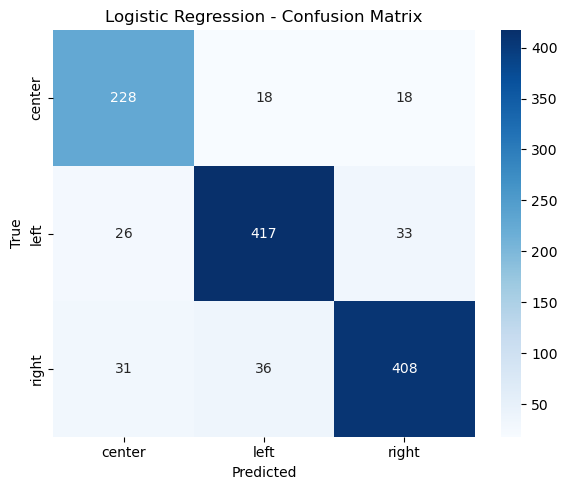


📘 Training Random Forest...
🕒 Time taken: 10.06 seconds
✅ Accuracy: 0.8814814814814815
📊 Classification Report:
               precision    recall  f1-score   support

      center       0.87      0.85      0.86       264
        left       0.90      0.88      0.89       476
       right       0.87      0.90      0.88       475

    accuracy                           0.88      1215
   macro avg       0.88      0.88      0.88      1215
weighted avg       0.88      0.88      0.88      1215



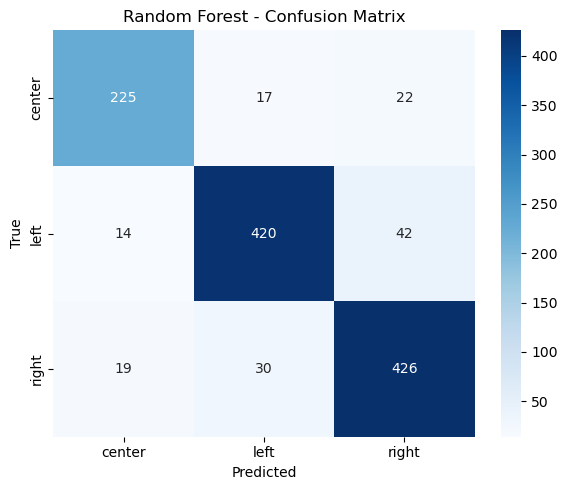


📘 Training Multinomial NB...
🕒 Time taken: 0.02 seconds
✅ Accuracy: 0.7728395061728395
📊 Classification Report:
               precision    recall  f1-score   support

      center       0.58      0.90      0.70       264
        left       0.92      0.68      0.78       476
       right       0.83      0.79      0.81       475

    accuracy                           0.77      1215
   macro avg       0.78      0.79      0.77      1215
weighted avg       0.81      0.77      0.78      1215



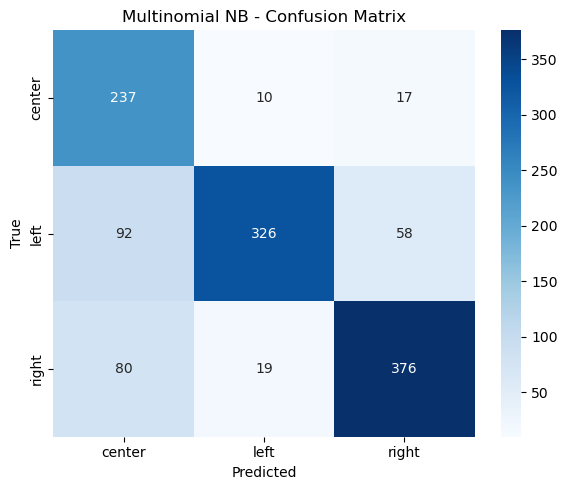


📘 Training Linear SVC...
🕒 Time taken: 0.20 seconds
✅ Accuracy: 0.9045267489711935
📊 Classification Report:
               precision    recall  f1-score   support

      center       0.87      0.87      0.87       264
        left       0.92      0.91      0.92       476
       right       0.91      0.92      0.91       475

    accuracy                           0.90      1215
   macro avg       0.90      0.90      0.90      1215
weighted avg       0.90      0.90      0.90      1215



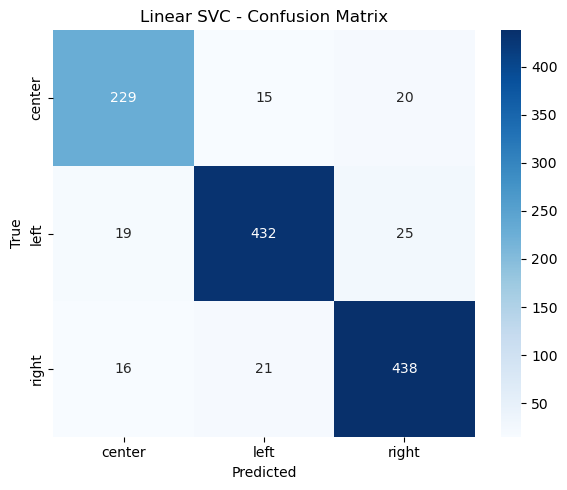


📘 Training XGBoost...


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [00:45:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🕒 Time taken: 42.93 seconds
✅ Accuracy: 0.837037037037037
📊 Classification Report:
               precision    recall  f1-score   support

      center       0.81      0.81      0.81       264
        left       0.86      0.82      0.84       476
       right       0.83      0.87      0.85       475

    accuracy                           0.84      1215
   macro avg       0.83      0.83      0.83      1215
weighted avg       0.84      0.84      0.84      1215



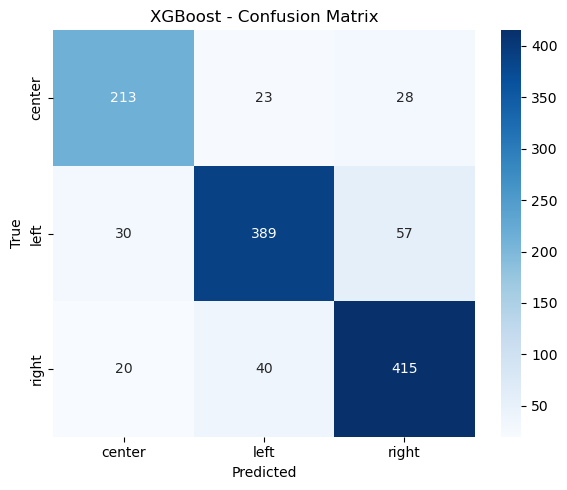

In [ ]:
import pandas as pd
import numpy as np
import time
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# === Load all datasets ===
df_mbic = pd.read_csv("final_labels_MBIC.csv", sep=";")
df_sg1 = pd.read_csv("final_labels_SG1.csv", sep=";")
df_sg2 = pd.read_csv("final_labels_SG2.csv", sep=";")

# Ensure all required columns exist
df_mbic["article"] = df_mbic["article"].fillna("")
df_sg1["article"] = ""
df_sg2["article"] = ""

# Concatenate datasets
df = pd.concat([df_mbic, df_sg1, df_sg2], ignore_index=True)

# Drop duplicates and nulls
df.drop_duplicates(inplace=True)
df.dropna(subset=["text", "topic", "type", "biased_words"], inplace=True)

# Combine text-based features
def combine_features(row):
    text = str(row["text"])
    topic = str(row["topic"])
    biased_words = " ".join(eval(row["biased_words"])) if isinstance(row["biased_words"], str) else ""
    article = str(row.get("article", ""))
    return f"{text} {topic} {biased_words} {article}"

df["input_text"] = df.apply(combine_features, axis=1)

# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df["cleaned_text"] = df["input_text"].apply(clean_text)

# Encode target labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["type"])  # 0=center, 1=left, 2=right (based on order)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["cleaned_text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced"),
    "Multinomial NB": MultinomialNB(), 
    "Linear SVC": LinearSVC(class_weight="balanced"),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# Evaluate models
for name, model in models.items():
    print(f"\n📘 Training {name}...")
    start_time = time.time()
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_vec)
    end_time = time.time()

    print(f" Time taken: {end_time - start_time:.2f} seconds")
    print(" Accuracy:", accuracy_score(y_test, y_pred))
    print(" Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [26]:
#sample test 

In [42]:
# === 5 Sample Articles to Test ===
test_articles = test_articles = [
    {
        "title": "Climate Crisis Escalates While Fossil Fuel Giants Rake in Record Profits",
"text":"""As wildfires rage across California, floods displace thousands in the Midwest, and heatwaves scorch cities from Texas to New York, the evidence is undeniable: the climate crisis is no longer a distant threat—it’s here. And yet, as communities suffer and ecosystems collapse, fossil fuel corporations continue to post record-breaking profits, protected by conservative politicians and a global system rigged in their favor.
In 2024 alone, the five largest oil companies reported over $200 billion in profits. Instead of investing in renewable energy or helping vulnerable communities transition to a green economy, these corporations funneled billions into stock buybacks and executive bonuses. Their message is clear: profits come before people, and the planet can burn so long as the shareholders stay rich.
Even more alarming is the political shielding they receive from right-wing lawmakers, many of whom deny climate science altogether. Republican leaders in Congress have repeatedly blocked climate legislation, gutted the Environmental Protection Agency’s regulatory powers, and prioritized drilling permits over clean air and water.
Meanwhile, climate activists—many of them youth, Indigenous leaders, and marginalized communities—continue to face police repression, surveillance, and criminalization. Peaceful protesters at pipeline sites are arrested, while oil spills and environmental destruction go unpunished.
We need a Green New Deal-level transformation: bold investments in wind, solar, and green infrastructure; the creation of millions of unionized green jobs; and climate reparations for communities hit hardest by pollution and environmental racism.
The time for delay is over. The time to act is now.""",
    },
    {
        "title": "Climate Crisis Escalates While Fossil Fuel Giants Rake in Record Profits",
        "text": """As wildfires rage across California, floods displace thousands in the Midwest, and heatwaves scorch cities from Texas to New York, the evidence is undeniable: the climate crisis is no longer a distant threat—it’s here. And yet, as communities suffer and ecosystems collapse, fossil fuel corporations continue to post record-breaking profits, protected by conservative politicians and a global system rigged in their favor.
In 2024 alone, the five largest oil companies reported over $200 billion in profits. Instead of investing in renewable energy or helping vulnerable communities transition to a green economy, these corporations funneled billions into stock buybacks and executive bonuses. Their message is clear: profits come before people, and the planet can burn so long as the shareholders stay rich.
Even more alarming is the political shielding they receive from right-wing lawmakers, many of whom deny climate science altogether. Republican leaders in Congress have repeatedly blocked climate legislation, gutted the Environmental Protection Agency’s regulatory powers, and prioritized drilling permits over clean air and water.
Meanwhile, climate activists—many of them youth, Indigenous leaders, and marginalized communities—continue to face police repression, surveillance, and criminalization. Peaceful protesters at pipeline sites are arrested, while oil spills and environmental destruction go unpunished.
We need a Green New Deal-level transformation: bold investments in wind, solar, and green infrastructure; the creation of millions of unionized green jobs; and climate reparations for communities hit hardest by pollution and environmental racism.
The time for delay is over. The time to act is now.""",
    },
    {
        "title": "Bipartisan Push Emerges for AI Regulation Amid Technological Boom",
        "text": """As artificial intelligence tools become increasingly integrated into everyday life—from health diagnostics to criminal justice systems—Democratic and Republican lawmakers alike are recognizing the need for clear regulatory frameworks.
A bipartisan group in Congress recently introduced the American AI Responsibility Act, aiming to address transparency, data privacy, and algorithmic bias. While the bill doesn’t go as far as some activists demand, it marks an important step toward balancing innovation with accountability.
Tech CEOs have expressed cautious support, stating that some regulation is needed to maintain public trust, but they warn against overregulation that could drive development offshore.
Experts agree: regulation must be careful, measured, and informed by the science—not by political theater. While divisions remain, the shared concern over AI’s risks may offer a rare opportunity for consensus in Washington.""",
    },
    {
        "title": "Republicans Block Minimum Wage Increase Despite Soaring Inequality",
        "text": """In yet another blow to working-class Americans, Senate Republicans have blocked legislation that would raise the federal minimum wage to $17 per hour by 2027. With wages stagnant and inflation hitting food, rent, and transportation costs, the move is being widely condemned by labor leaders and economists.
The current $7.25 minimum wage has not been raised since 2009, despite historic gains in productivity and corporate profits. Over 60% of Americans support a raise, but Republican lawmakers claim it would “hurt small businesses”—an argument that many economists say is overblown.
In reality, the refusal to raise wages preserves exploitative systems where billion-dollar corporations rely on underpaid workers while CEO salaries skyrocket.
This is not just about economics—it’s about dignity. Every American who works full-time should be able to afford basic necessities. Congress’s failure to act is a moral failure, and it’s up to voters to hold them accountable.""",
    },
    {
        "title": "Border Security Improves Under New Enforcement Measures",
        "text": """The southern border has long been a flashpoint in American politics, but recent data shows that tougher enforcement and advanced surveillance technology are yielding results. Illegal crossings dropped 30% in the first quarter of 2025 compared to the previous year, according to Homeland Security reports.
Under the new measures, authorities have deployed AI-powered drones, reinforced border fencing, and accelerated asylum screening procedures. Critics on the left say the policies are “inhumane,” but officials argue they are necessary to protect national sovereignty and public safety.
Drug seizures have also increased, particularly fentanyl shipments originating from cartels that exploit weak border points. Law enforcement agencies say the new tools and funding are making a significant impact.
The Biden administration was slow to act early in its term, but this policy shift marks a necessary correction. The right to immigrate must be balanced with the rule of law—and American citizens deserve to feel safe and secure in their own country.""",
    },
    {
        "title":"Katy Perry says 'no place like home' in first post after space trip",
        "text": """Pop star Katy Perry shared her first post following her space return on Monday. Seemingly signalling her relief of coming back to Earth, the singer expressed her happiness about returning to her home. Perry was one of the few civilians who traveled to space aboard Blue Origin's New Shepard spacecraft for 11 minutes.\n\nOn Tuesday, Katy Perry wrote on X, \"There's no place like home (red heart and Earth emoji) (sic).\"\n\nadvertisement\n\nHere's the post:\n\nPop star Katy Perry and five other women made history on Monday, becoming the first all-female crew in over 60 years to launch into space. The group flew aboard Blue Origin’s NS-31 mission, marking a significant milestone in space tourism.\n\nThe New Shepard rocket carried singer Perry, along with Jeff Bezos’s fiance Lauren Sanchez, civil rights advocate Amanda Nguyen, journalist Gayle King, and former NASA rocket scientist Aisha Bowe to an altitude of more than 65 miles (105 kilometres) above the Earth’s surface.\n\nThe 11-minute suborbital flight lifted off from West Texas and safely returned after reaching the edge of space, offering the crew a few fleeting moments of weightlessness.\n\nKaty Perry sang 'What a Wonderful World' during her time in space.\n\nPublished By: Anisha Rao Published On: Apr 15, 2025""",
    },
    {
        "title": "Robert Vadra questioned for 3 hours by ED in land deal case, cries 'witch hunt'",
        "text": """Robert Vadra, the husband of Congress MP Priyanka Gandhi, labelled the summons by the ED in connection with its money-laundering probe into the Shikhopur land deal a \"witch hunt\" and \"political vendetta\". Vadra was questioned for three hours after he marched to the ED office from his residence in Delhi as the federal agency called him for a second time for questioning.\n\nadvertisement\n\nAfter leaving the ED office, Vadra claimed that whenever he speaks out against the Narendra Modi government and its policies, the Centre begins misusing central agencies. Dismissing the case as a tool for harassment, Vadra told reporters, \"There is nothing in the case. For the last twenty years, I have been summoned 15 times and interrogated for more than 10 hours every time. I have submitted 23000 documents.\"\n\nAhead of the questioning, Vadra said, \"It is a political vendetta. Central agencies are being misused by the government.\"\n\nAlleging that the federal agencies are being misused, Vadra, brother-in-law of Leader of the Opposition Rahul Gandhi, told India Today TV, \"They are trying to silence me. They stop Rahul in Parliament...\"\n\n\"Whenever I speak up for people and make them heard, they will try to suppress me... I have always given all the answers and continue to do so,\" he added as he was heading to the ED office.\n\nadvertisement\n\nVadra had skipped the first summons, which was issued on April 8. The central investigating agency is looking into the alleged financial irregularities concerning his firm, Skylight Hospitality.\n\nAs per the ED, Vadra's company had purchased a 3.5-acre plot in Gurgaon's Shikophur from Omkareshwar Properties for Rs 7.5 crore back in February 2008.\n\nVadra's company, subsequently, 
        sold the parcel of land for Rs 58 crore to real estate giant DLF. Suspecting the proceeds to be part of a laundering scheme, the central agency is probing the money trail behind the windfall gains.\n\nOnce Vadra appears for questioning, his statement will be recorded under the Prevention of Money Laundering Act (PMLA).\n\nPublished By: sharangee Published On: Apr 15, 2025""",
    },
    {
        "title": "Bangladeshi miscreants involved in Bengal Waqf violence, Centre told: Sources",
        "text": """An initial probe into the massive violence that rocked West Bengal over the Waqf law has revealed the involvement of Bangladeshi miscreants, the Union Home Ministry was informed, according to sources.\n\nThe probe also found that the Mamata Banerjee-led government failed to monitor the intruders as unrest gripped Murshidabad district and South 24 Parganas during protests over the Waqf law, killing three people and injuring several others.\n\nadvertisement\n\nAmong those killed were a father-son duo who were hacked to death by a mob in Samsherganj. Two brothers were arrested on Tuesday for the murder.\n\nWest Bengal, which has over 80,480 Waqf properties - second only to Uttar Pradesh's 2.2 lakh, has witnessed widespread protests after the passage of the Waqf law earlier this month.\n\nThe law, which expands the government's role in regulating Waqf properties, is being seen by a section of the Muslim community as a move to \"snatch\" their land. The Centre has rejected such claims.\n\nHOW UNREST BROKE OUT IN BENGAL\n\nSeveral shops and vehicles were torched and homes of locals were ransacked after protests against the Waqf law turned violent in Suti and Samserganj of Murshidabad district. A large number of locals have also fled these areas since unrest gripped the Muslim-majority district on April 11.\n\nadvertisement\n\nMurshidabad, which borders Bangladesh, has a 66% Muslim population, according to the 2011 Census.\n\nThe unrest spilled over to Bhangar in South 24 Parganas district on Monday when a protest led by the India Secular Front (ISF) against the Waqf law turned violent. Protesters clashed with police and set fire to vehicles after they were stopped from heading to Kolkata.\n\nAmid the violence, Bengal Governor CV Ananda Bose sought a detailed report from the Trinamool government. The Calcutta High Court has also stepped in, ordering the deployment of central forces in sensitive areas.\n\nMeanwhile, Chief Minister Mamata Banerjee appealed for calm and claimed that the contentious legislation wouldn't be implemented in the state.\n\nPolice said a total of 210 people have so far been arrested in connection with the violence and the situation in Murshidabad was gradually returning to normal.\n\nPublished By: sharangee Published On: Apr 15, 2025""",
    }
]

In [31]:


# === Process and Predict ===
print("\n📌 Predictions on Sample Articles:")
for i, article in enumerate(test_articles, 1):
    combined_text = article["title"] + " " + article["text"]
    cleaned = clean_text(combined_text)
    vec = vectorizer.transform([cleaned])
    prediction = model.predict(vec)[0]
    predicted_label = le.inverse_transform([prediction])[0]
    print(f"Article {i} → Predicted Bias: {predicted_label}")



📌 Predictions on Sample Articles:
Article 1 → Predicted Bias: left
Article 2 → Predicted Bias: left
Article 3 → Predicted Bias: left
Article 4 → Predicted Bias: left
Article 5 → Predicted Bias: left


In [33]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')

# === Load all datasets ===
df_mbic = pd.read_csv("final_labels_MBIC.csv", sep=";")
df_sg1 = pd.read_csv("final_labels_SG1.csv", sep=";")
df_sg2 = pd.read_csv("final_labels_SG2.csv", sep=";")

# Ensure all required columns exist
df_mbic["article"] = df_mbic["article"].fillna("")
df_sg1["article"] = ""
df_sg2["article"] = ""

# Concatenate datasets
df = pd.concat([df_mbic, df_sg1, df_sg2], ignore_index=True)

# Drop duplicates and nulls
df.drop_duplicates(inplace=True)
df.dropna(subset=["text", "topic", "type", "biased_words"], inplace=True)

# === Load and Prepare Dataset ===
#df = pd.read_csv("your_dataset.csv", sep=";")

# Combine text and biased_words
df["biased_words"] = df["biased_words"].fillna("[]")
df["biased_words"] = df["biased_words"].apply(eval).apply(lambda x: " ".join(x))
df["text"] = df["text"].fillna("") + " " + df["biased_words"]
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True)

# Clean text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = [stemmer.stem(w) for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

df["text_clean"] = df["text"].apply(clean_text)

# Encode target labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["type"])

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(df["text_clean"], df["label"], test_size=0.2, stratify=df["label"], random_state=42)

# === Vectorize ===
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# === Handle Imbalance with SMOTE ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vec, y_train)

# === Try Multiple Classifiers ===
classifiers = [
    ("Logistic Regression", LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    ("LinearSVC", LinearSVC(class_weight='balanced', max_iter=1000, random_state=42)),
    ("Random Forest", RandomForestClassifier(class_weight='balanced', random_state=42)),
    ("Naive Bayes", MultinomialNB()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

best_f1 = 0
best_model = None
best_model_name = ""

print(" Comparing Models:\n")
for name, clf in classifiers:
    clf.fit(X_train_res, y_train_res)
    preds = clf.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')
    print(f"{name}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_model = clf
        best_model_name = name

# Set best model as final model
model = best_model
print(f"\n Best Model: {best_model_name} (F1 = {best_f1:.4f})")

# === Test Evaluation ===
test_preds = model.predict(X_test_vec)
print("\n Test Set Results:")
print("Accuracy:", accuracy_score(y_test, test_preds))
print("Classification Report:")
print(classification_report(y_test, test_preds, target_names=le.classes_))

# Plot confusion matrix
#conf_mat = confusion_matrix(y_test, test_preds)
#sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
#plt.xlabel("Predicted")
#plt.ylabel("True")
#plt.title("Confusion Matrix")
#plt.show()




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 Comparing Models:

Logistic Regression: Accuracy = 0.8650, F1 = 0.8562
LinearSVC: Accuracy = 0.9177, F1 = 0.9117
Random Forest: Accuracy = 0.9226, F1 = 0.9168
Naive Bayes: Accuracy = 0.7761, F1 = 0.7707


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:14:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Accuracy = 0.8576, F1 = 0.8490

 Best Model: Random Forest (F1 = 0.9168)

 Test Set Results:
Accuracy: 0.922633744855967
Classification Report:
              precision    recall  f1-score   support

      center       0.91      0.86      0.88       264
        left       0.92      0.95      0.93       476
       right       0.93      0.93      0.93       475

    accuracy                           0.92      1215
   macro avg       0.92      0.91      0.92      1215
weighted avg       0.92      0.92      0.92      1215



In [43]:
# === Process and Predict ===
print("\n Predictions on Sample Articles:")
for i, article in enumerate(test_articles, 1):
    combined_text = article["title"] + " " + article["text"]
    cleaned = clean_text(combined_text)
    vec = vectorizer.transform([cleaned])
    prediction = model.predict(vec)[0]
    predicted_label = le.inverse_transform([prediction])[0]
    print(f"Article {i} → Predicted Bias: {predicted_label}")


 Predictions on Sample Articles:
Article 1 → Predicted Bias: center
Article 2 → Predicted Bias: center
Article 3 → Predicted Bias: center
Article 4 → Predicted Bias: left
Article 5 → Predicted Bias: right
Article 6 → Predicted Bias: center
Article 7 → Predicted Bias: center
Article 8 → Predicted Bias: center


### combine csv and json data

In [51]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.pipeline import Pipeline
import json

# Label mapping to standardize bias categories
label_mapping = {
    "Left": "left",
    "Slightly Left": "left",
    "Slightly left": "left",
    "Extreme Left": "left",
    "Right": "right",
    "Slightly Right": "right",
    "Extreme Right": "right",
    "Center-Right": "right",
    "Center/Slightly Right": "right",
    "Center": "center",
    "Slightly Center": "center",
    "Center/Slightly Left": "center",
    "Center/Left": "center",
    "Center-Left": "center"
}


# NLP text preprocessing functions
def clean_text(text):
    # Remove stopwords, stemming
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    words = text.split()
    cleaned_words = [ps.stem(word.lower()) for word in words if word.lower() not in stop_words]
    return " ".join(cleaned_words)

# === Load all datasets ===
df_mbic = pd.read_csv("final_labels_MBIC.csv", sep=";")
df_sg1 = pd.read_csv("final_labels_SG1.csv", sep=";")
df_sg2 = pd.read_csv("final_labels_SG2.csv", sep=";")

# Ensure all required columns exist
df_mbic["article"] = df_mbic["article"].fillna("")
df_sg1["article"] = ""
df_sg2["article"] = ""

# Concatenate datasets
df_csv = pd.concat([df_mbic, df_sg1, df_sg2], ignore_index=True)

# Drop duplicates and nulls
df_csv.drop_duplicates(inplace=True)
df_csv.dropna(subset=["text", "topic", "type", "biased_words"], inplace=True)
# Load CSV data (assuming CSV has columns like 'text', 'type', etc.)
#csv_file_path = 'your_csv_file.csv'  # Replace with your CSV file path
#df_csv = pd.read_csv(csv_file_path, delimiter=';')

# Load JSON data (assuming JSON has columns 'title', 'text', 'keywords', 'bias_category')
json_files = ['india_today_analyzed.json']  # Replace with your JSON file paths
json_data = []

for file in json_files:
    with open(file, 'r') as f:
        data = json.load(f)
        for entry in data:
            json_data.append({
                'title': entry['title'], 
                'text': entry['text'], 
                'keywords': " ".join(entry['keywords']),  # Convert list of keywords into space-separated string
                'bias_category': entry['analysis']['bias_category']  # Extract bias category from analysis
            })

df_json = pd.DataFrame(json_data)

# Apply the label mapping to convert bias categories in both CSV and JSON
df_csv['type'] = df_csv['type'].map(label_mapping)  # Mapping 'type' in CSV
df_json['bias_category'] = df_json['bias_category'].map(label_mapping)  # Mapping 'bias_category' in JSON

# Drop rows with any null values in important columns
df_csv.dropna(subset=["text", "type"], inplace=True)
df_json.dropna(subset=["text", "bias_category"], inplace=True)

# Combine text features in both CSV and JSON
df_csv["input_text"] = df_csv["text"].astype(str) + " " + df_csv["type"].astype(str) + " " + df_csv["biased_words"].astype(str)
df_json["input_text"] = df_json["title"].astype(str) + " " + df_json["text"].astype(str) + " " + df_json["keywords"].astype(str)

# Encode target labels for both CSV and JSON
le = LabelEncoder()
df_csv["label"] = le.fit_transform(df_csv["type"])  # Label encoding for CSV
df_json["label"] = le.fit_transform(df_json["bias_category"])  # Label encoding for JSON

# Combine CSV and JSON datasets
df_combined = pd.concat([df_csv[['input_text', 'label']], df_json[['input_text', 'label']]], axis=0)

In [52]:
df_combined["label"].value_counts()

label
0.0    159
1.0     23
2.0     18
Name: count, dtype: int64

In [ ]:
# To test with your new articles
test_articles = [
    {
        "title": "Climate Crisis Escalates While Fossil Fuel Giants Rake in Record Profits",
        "text": "As wildfires rage across California, floods displace thousands in the Midwest...",
    },
    {
        "title": "America’s Strength Lies in Its Free Markets, Not Government Control",
        "text": "The United States thrives when government steps back and lets free enterprise lead...",
    },
    {
        "title": "Bipartisan Push Emerges for AI Regulation Amid Technological Boom",
        "text": "As artificial intelligence tools become increasingly integrated into everyday life...",
    },
    {
        "title": "Republicans Block Minimum Wage Increase Despite Soaring Inequality",
        "text": "In yet another blow to working-class Americans, Senate Republicans have blocked legislation...",
    },
    {
        "title": "Border Security Improves Under New Enforcement Measures",
        "text": "The southern border has long been a flashpoint in American politics, but recent data shows...",
    }
]

# Predict the sample articles
print("\n📌 Predictions on Sample Articles:")
for i, article in enumerate(test_articles, 1):
    combined_text = article["title"] + " " + article["text"]
    cleaned = clean_text(combined_text)
    vec = vectorizer.transform([cleaned])
    prediction = pipeline.predict(vec)[0]
    predicted_label = le.inverse_transform([prediction])[0]
    print(f"Article {i} → Predicted Bias: {predicted_label}")